# setup

In [ ]:
tables = ['volc.csv']
mydrive= 'E:/mydoc/git/trade/analyics/'
# """
tables = ['volcvn.csv','volcvt.csv','volcva.csv','volcvg.csv']
from google.colab import drive
drive.mount('/content/drive')
mydrive='/content/drive/MyDrive/volrt/new/'
# Requirements:
%pip install git+https://github.com/jerronl/rtdl.git
#"""

appname='Xch_'
duration = 6
bad_value=-99999
vars_h, cat_names, ys,vars_c,= (
    ['date', 'diff', 'spot'],
    [],
    [[
        'close', 'hi', 'lo',
        'dtm','level','slope','curve',
         'dtm1','level1','slope1','curve1',
         'dtm2','level2','slope2','curve2',
         'dtm3','level3','slope3','curve3'],
         [ 'pmcat',],],
    ['Horizon','spot'],
)
import numpy as np

vars_h+=ys[0]
dep_vars=ys#[duration]
# vars_c=vars_c[duration]

ignore_load_zero=ignore_load_error=y_std=y_mean=X=y=loss_fn=my_model=jobsize=offset=start_epoch=optimizer = None

import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import rtdl.zero as zero
import matplotlib.pyplot as plt,os
%matplotlib inline
from typing import Optional
from torch import Tensor
import torch.nn as nn
import math
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pickle import dump, load
import seaborn as sns
import random
from datetime import datetime

# !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.13-cp38-cp38-linux_x86_64.whl --force-reinstall
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

device = torch.device('cuda')
zero.improve_reproducibility(seed=1234567)
batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*12
print(f'GPU mem:{int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)}G, batch_size:{batch_size}')


Mounted at /content/drive
  Cloning https://github.com/jerronl/rtdl.git to /tmp/pip-req-build-lxobi5ej
  Running command git clone --filter=blob:none --quiet https://github.com/jerronl/rtdl.git /tmp/pip-req-build-lxobi5ej
  Resolved https://github.com/jerronl/rtdl.git to commit f98ce61e5574c18e249a21e417e208f4832de808
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rtdl: filename=rtdl-0.0.14.dev0-py3-none-any.whl size=77961 sha256=e4580f68e4dd688e7e0547d8b9022e51d82d176102b01e3905a95ac52b483452
  Stored in directory: /tmp/pip-ephem-wheel-cache-jdekv9ml/wheels/8d/92/7b/32aaeaca71d3de56c377bd2561972e24497e709ff9f9d967cc
Successfully built rtdl
GPU mem:16G, batch_size:256


In [ ]:
int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*16

256

# model

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000, position=None):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        if position is None:
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class PETrans(nn.Module):

    def __init__(self, duration, d_model,n_num_features,cat_cardinalities,d_out,x2):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        print("PETrans",duration, d_model,n_num_features,cat_cardinalities,d_out,x2)
        super().__init__()
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Linear(duration, d_model*2), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Dropout(0.1), #self.hparams.input_dropout),
            nn.GELU(), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Linear(d_model*2, d_model), # self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.unf=nn.Flatten(1,2)
        self.ftt= rtdl.FTTransformer.make_default(
            n_num_features=int(n_num_features/duration*d_model+x2),
            cat_cardinalities=cat_cardinalities,
            d_out=d_out,
            )

    def forward(self, x_num: Optional[Tensor], x_cat: Optional[Tensor], x2: Optional[Tensor]) -> Tensor:
        x = self.input_net(x_num)
        x = self.positional_encoding(x)
        x = self.unf(x)
        x = torch.cat((x, x2), 1)
        x = self.ftt(x, x_cat)
        return x

    def make_default_optimizer(self) -> torch.optim.AdamW:
        """Make the optimizer for the default FT-Transformer."""
        return self.ftt.make_default_optimizer()

def apply_model(model, x_num, x_cat=None, x2=None):
    return model(x_num, x_cat, x2)

@torch.no_grad()
def evaluate(mload=None,part='val'):
    model=mload or my_model
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], batch_size):
        prediction.append(apply_model(model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y[part]
    prediction2 = prediction[:,-y_cat:].argmax(1)
    mask = ~torch.isnan(target[:,:-1])
    score = (F.mse_loss(prediction[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
          ((target[:,-1]!=prediction2).sum()/len(prediction))

    return score,target, prediction,prediction2

@torch.no_grad()
def validate(mload=None):
  score,target, prediction,prediction2 = evaluate(mload,'test')
  print(jobname,f'{score:.4f}')
  target, prediction, prediction2 = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy(), prediction2.cpu().numpy()
  sns.jointplot(x=target[:,-1] , y=prediction2,kind="kde",fill=True,rug=True)
  prediction[:,-y_cat]=prediction2
  sns.set(style="whitegrid")
  dep_var=dep_vars[0]+dep_vars[1]
  figs=min(len(dep_var),4)
  _, axes = plt.subplots(math.ceil(len(dep_var)/figs), figs, figsize=(16,16))
  for i,name in enumerate(dep_var):
      axs=axes.flat[i] if figs>1 else axes
      sns.regplot(ax=axs, x=target[:,i] , y=prediction[:,i],
                scatter_kws = {'color': 'purple', 'alpha': 0.3},
                line_kws = {'color': '#CCCC00', 'alpha': 0.3}
                )
      axs.set_title(name)
      mask=~np.isnan(target[:,i])
      if not dep_var[i][:3] in ['dtm','pmc']:
        axs.set_xlim(left=max(np.min(target[:,i][mask]), -2.5),
                      right=min(np.max(target[:,i][mask]),2.5))
      else:
        axs.set_xlim(left=np.min(target[:,i][mask]),
                            right=np.max(target[:,i][mask]))
  plt.show()

def cross_entropy_mse_loss_with_nans(input, target):
    mask = ~torch.isnan(target[:,:-1])
    return (F.mse_loss(input[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
      (F.cross_entropy (input[:,-y_cat:],target[:,-1].type(torch.LongTensor).to(device)))

def model_path():
  return mydrive+jobname+'checkpoint.pt'

def save_model(improved=False):
  path=mydrive+jobname+'checkpoint.pt'
  torch.save(
      {
          'model':  my_model.state_dict() if improved or not os.path.exists(path) else #else #
                    torch.load(path)['model'],
          'optimizer': optimizer.state_dict(),
          'epoch': epoch,
          'random_state': zero.random.get_state (),
          'jobsize': jobsize,
          'offset': offset,
      },
      path
  )

def load_model():
  global jobsize,offset,start_epoch,my_model,optimizer
  start_epoch=1
  jobsize=int(len(X_all)*0.1)
  if resume:
    path=mydrive+jobname+'checkpoint.pt'
    if os.path.exists(path):
      try:
        checkpoint = torch.load(path,map_location=device)
        my_model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        try:
          zero.random.set_state(checkpoint['random_state'])
        except (AssertionError,) as err:
          if ignore_load_zero:
            print("zero error:",err)
          else:
            raise err
        print(f'loaded {jobname} epoch {start_epoch}')
        if 'jobsize' in checkpoint and checkpoint['jobsize']==jobsize:
          offset=checkpoint['offset']
        else:
          raise ValueError('size diffs now',jobsize,
                checkpoint['jobsize'] if 'jobsize' in checkpoint else 0)
        return True
      except Exception as error:
        if ignore_load_error:
          print("failed to load: ", error)
        else:
          raise error
  random.seed(datetime.now().timestamp())
  offset=random.randint(-jobsize*3,-jobsize*2)
  return False

def job_name():
  return appname+''.join(filter(lambda x: x not in "[' ", str(dep_vars[0])))[:8]

def setup_data():
  global jobname,X,y, my_model,optimizer,train_loader,progress,y_mean,y_std,loss_fn,y_cat
  dep_var=dep_vars[0]+dep_vars[1]
  jobname=job_name()
  y_all=torch.tensor(dfo.loc[:,dep_var].to_numpy(), device=device)

  y_cat = int(max(y_all[:,-1]))
  y_all[:,-1]-=1
  d_out = y_cat+y_all.shape[1]-1
  print(jobname,y_all.shape)

  X,y = {},{}
  my_model=PETrans(
      duration=duration,
      d_model=16,
      n_num_features=len(cont_names),
      cat_cardinalities=[len(arr) for arr in enc.categories_],
      d_out=d_out,
      x2=len(vars_c)
      ).to(device)

  optimizer = (
      my_model.make_default_optimizer()
  )
  load_model()
  print('offset ',offset)
  X['train'], X['test'], y['train'], y['test']  = (
      np.concatenate((X_all[:offset],X_all[offset+jobsize:])),
      X_all[offset:offset+jobsize],
      torch.cat((y_all[:offset],y_all[offset+jobsize:])),
      y_all[offset:offset+jobsize],
  )
  X['train'], X['val'],  y['train'], y['val']  = sklearn.model_selection.train_test_split(
      X['train'], y['train'], train_size=0.9
  )
  X2, X['test'], y2, y['test']  = sklearn.model_selection.train_test_split(
      X['test'], y['test'], train_size=0.05
  )
  X['val'], y['val']=np.concatenate((X['val'], X['test'])),torch.cat(( y['val'], y['test']))
  X['train'], y['train']=np.concatenate((X['train'], X2)),torch.cat(( y['train'], y2))

  X = {
      k: (torch.tensor(v[:,:len(cat_names)], device=device).to(torch.int64),
          torch.tensor(v[:,-len(cont_names):].reshape((v.shape[0],int(len(cont_names)/duration),duration)), device=device),
          torch.tensor(v[:,len(cat_names):-len(cont_names)], device=device),)
      for k, v in X.items()
  }
  # y = {k: torch.tensor(v, device=device) for k, v in y.items()}
  mask=torch.masked.masked_tensor(y['train'],y['train']!=bad_value)
  y_mean,y_std=mask.mean(dim=0).to_tensor(0),mask.std(dim=0).to_tensor(0)
  cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
  for k,v in y.items():
    v[v==bad_value]=float('nan')
    v[:,cols_to_norm]=((v-y_mean) / y_std)[:,cols_to_norm]
    y[k]=v


  y = {k: v.float() for k, v in y.items()}

  train_loader = zero.data.IndexLoader(len(X['train'][0]), batch_size, device=device)
  progress = zero.ProgressTracker(patience=100)
  loss_fn = cross_entropy_mse_loss_with_nans

def boxplot(vars,bad_value=None):
  i=j=min(5,len(vars))
  for _,var in enumerate(vars):
      if isinstance(var,list):
        y=pd.Series()
        for name in var:
          if name in dfo.columns:
            y=y.append(dfo[name],ignore_index = True)
      else:
        y=dfo[var] if var in dfo.columns else []
        name=var
      if len(y)>0:
        if i>=j:
          figure, axes = plt.subplots(1,j,figsize=(16,8))
          i=0
        axs=axes.flat[i]
        i+=1
        if bad_value is not None and y.min()<=bad_value:
          mask=y!=bad_value
          name=f'{name}_{mask.sum()/len(mask):.0%}'
          y=y[mask]
        sns.boxplot(ax=axs, y=y, showmeans=True,
                          meanprops={"marker": "+",
                        "markeredgecolor": "black",
                        "markersize": "10"})
        axs.set_title(name)
  plt.show()


def set_state(state: Dict[str, Any]) -> None:
    """Set global random states in `random`, `numpy` and `torch`.

    Args:
        state: global RNG states. Must be produced by `get_state`. The size of the list
            :code:`state['torch.cuda']` must be equal to the number of available cuda
            devices.

    See also:
        `get_state`

    Raises:
        AssertionError: if :code:`torch.cuda.device_count() != len(state['torch.cuda'])`
    """
    random.setstate(state['random'])
    np.random.set_state(state['numpy.random'])
    torch.random.set_rng_state(state['torch.random'].cpu())
    assert torch.cuda.device_count() == len(state['torch.cuda'])
    torch.cuda.set_rng_state_all([v.cpu() for v in state['torch.cuda']])  # type: ignore

zero.random.set_state=set_state


In [ ]:
import gc

my_model.cpu()
del my_model
gc.collect()
torch.cuda.empty_cache()

# Training

(250127, 156) (250127, 134) 19
0.439744609738253 0.000000   -2.264210
0.005000   -2.094034
0.050763   -1.733540
0.096525   -1.548420
0.142288   -1.364280
0.188050   -1.206910
0.233813   -1.134600
0.279576   -0.993440
0.325338   -0.615870
0.371101   -0.309750
0.416863   -0.069010
0.466185    0.151861
0.519067    0.333930
0.571948    0.548960
0.624830    0.756340
0.677711    1.045780
0.730593    1.280870
0.783474    1.483100
0.836356    1.636240
0.889237    1.830140
0.942119    2.107490
0.995000    2.680794
1.000000    3.136000
Name: close, dtype: float64


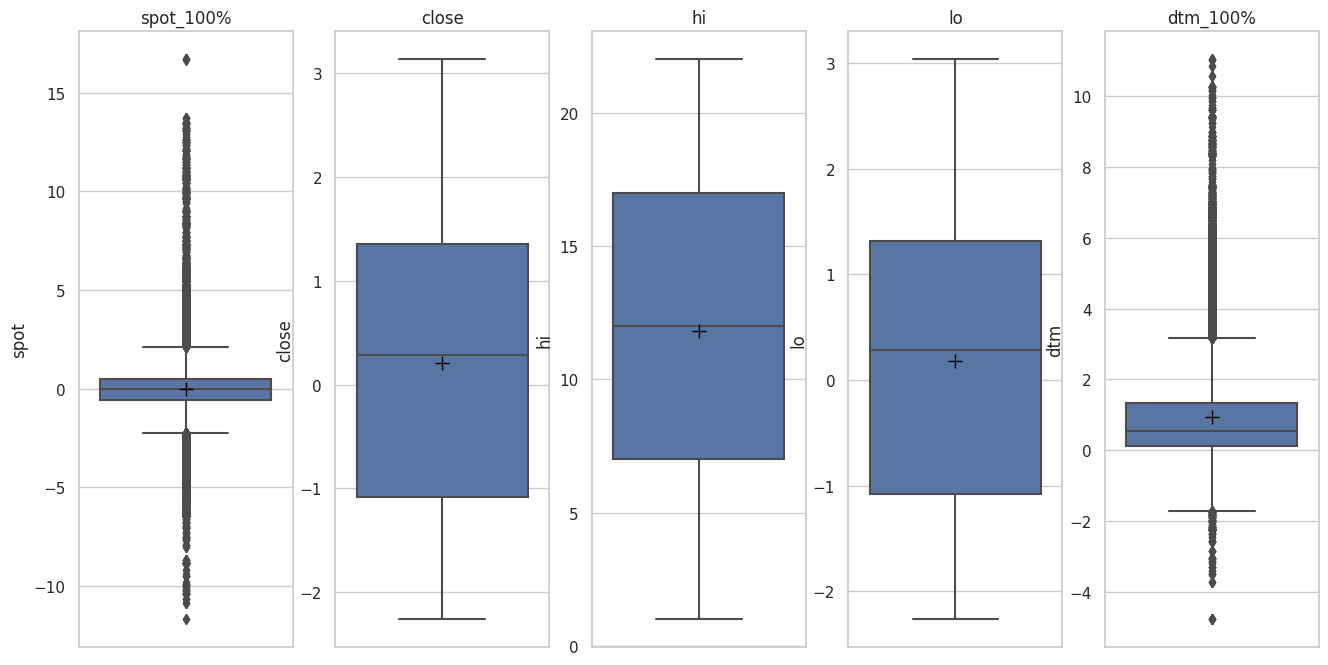

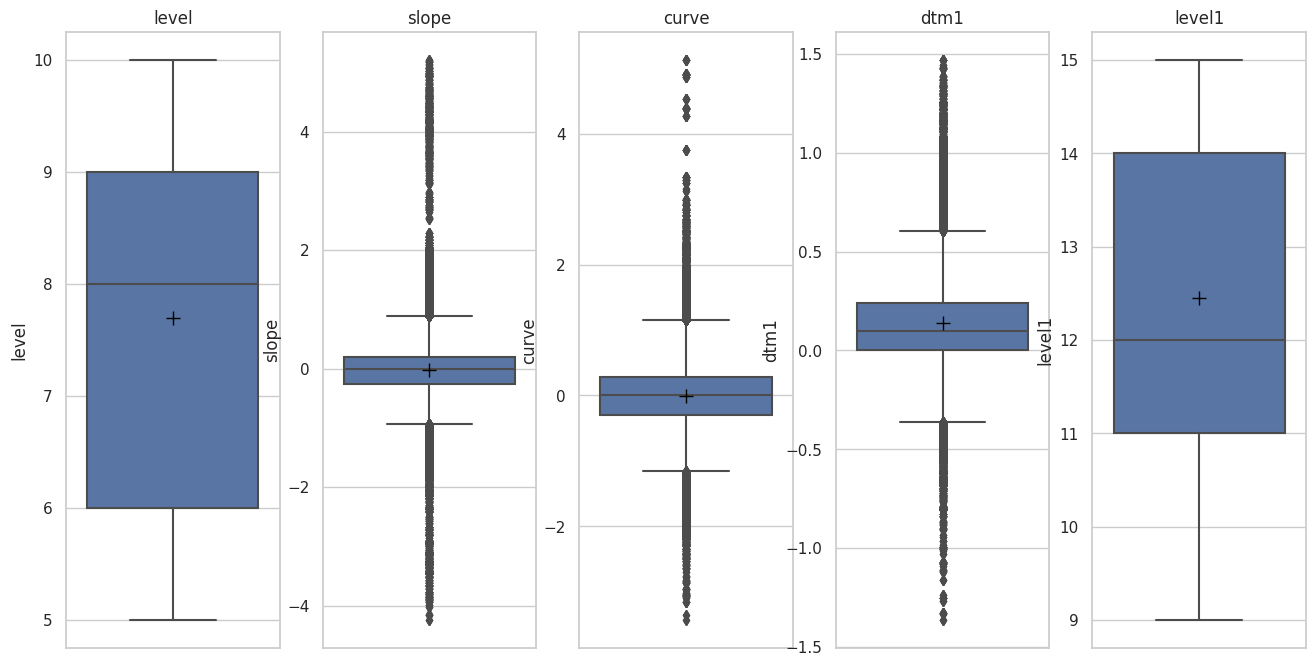

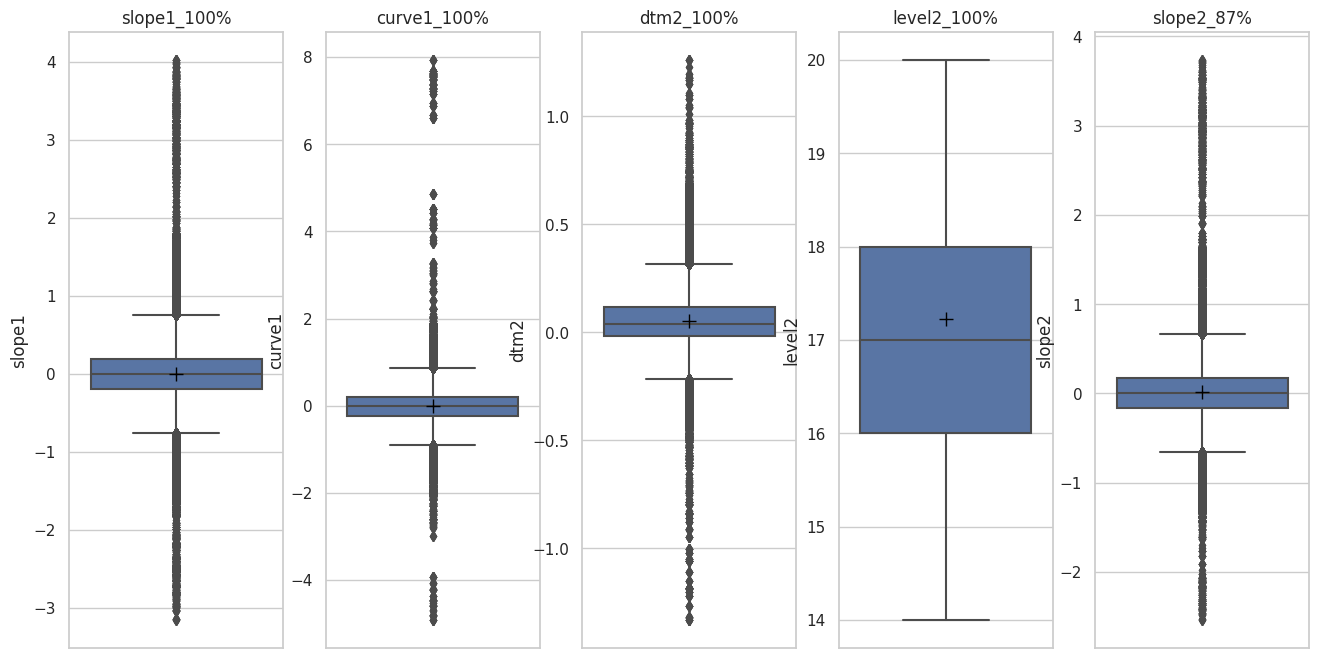

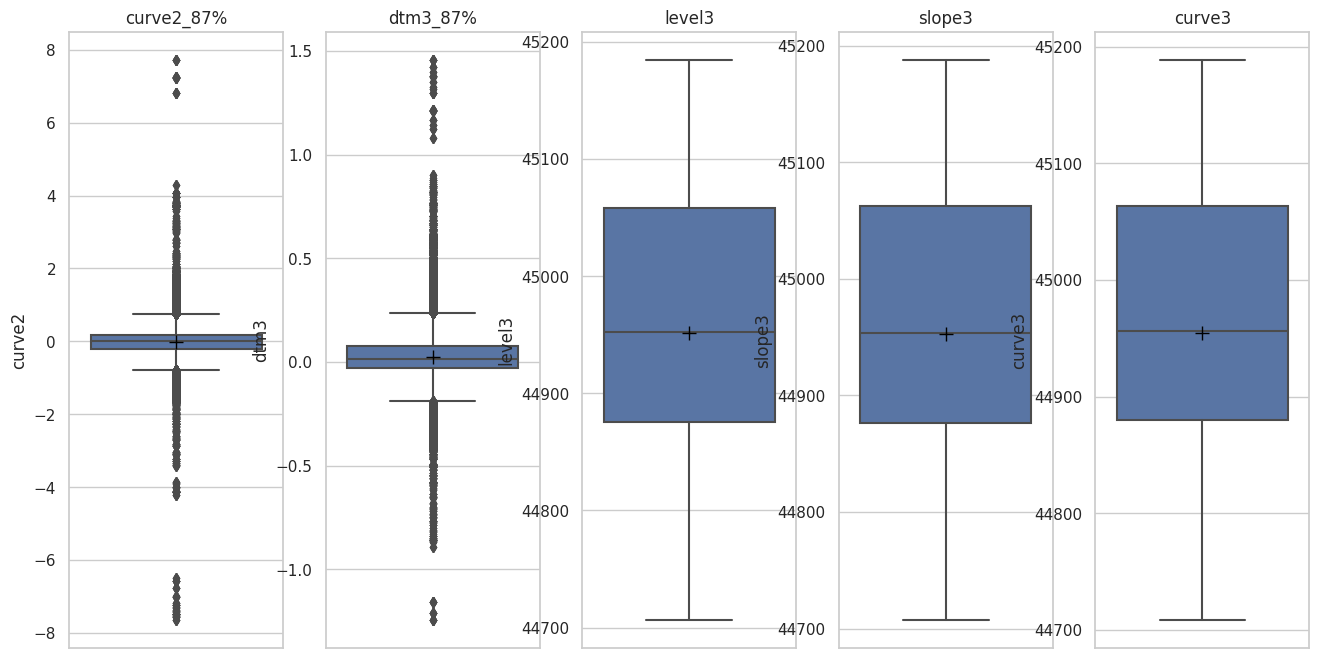

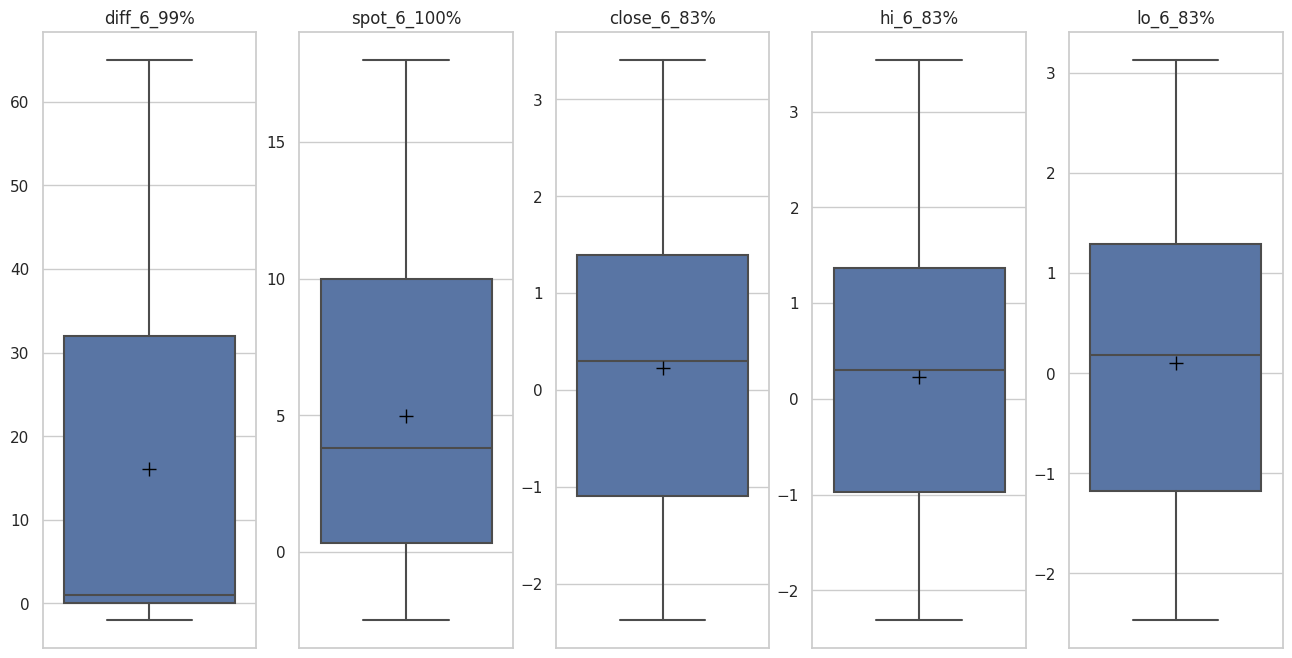

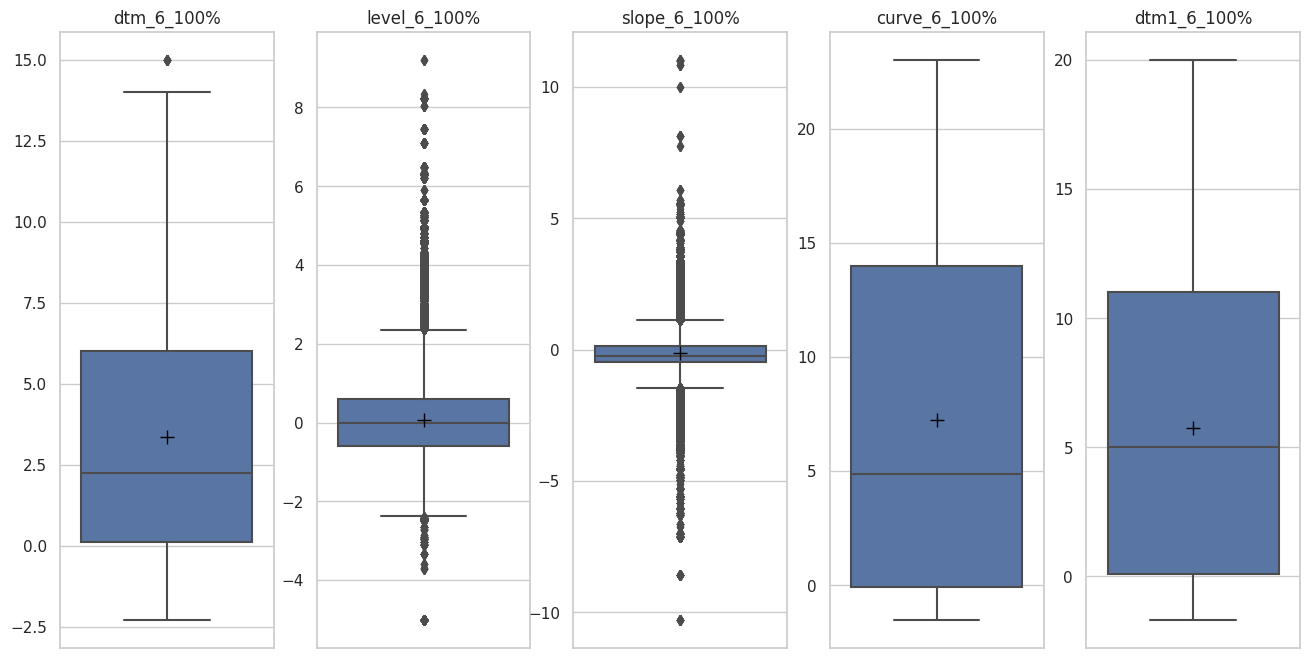

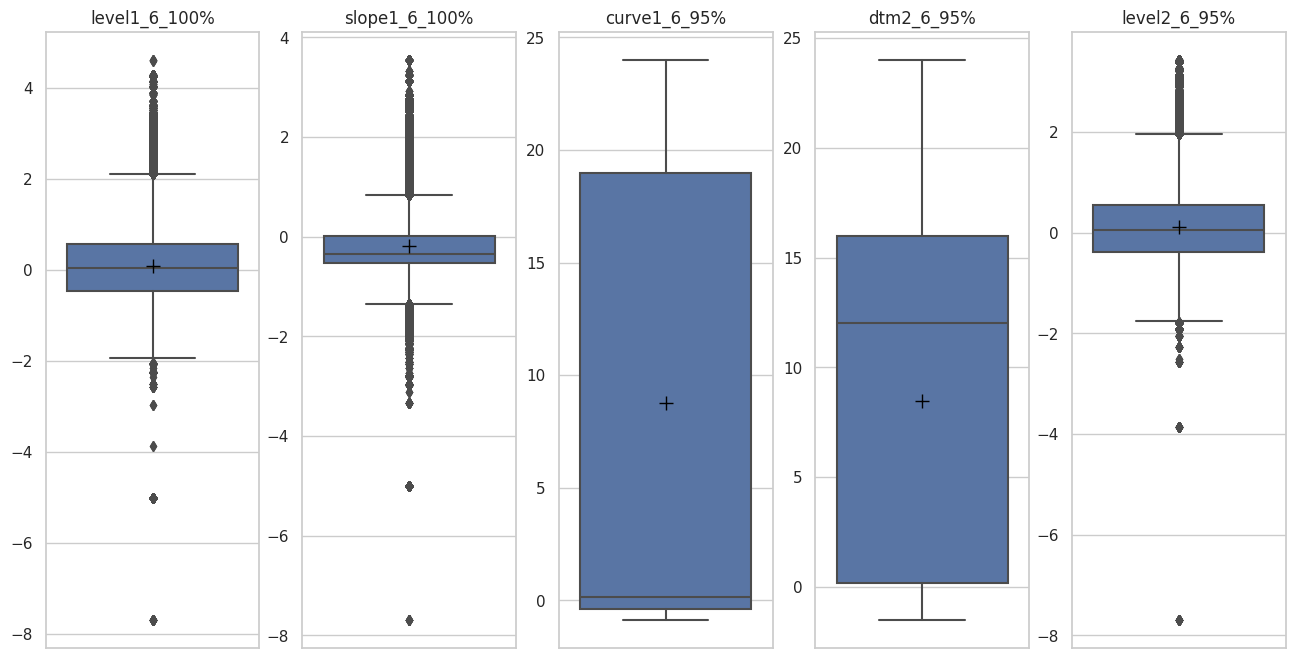

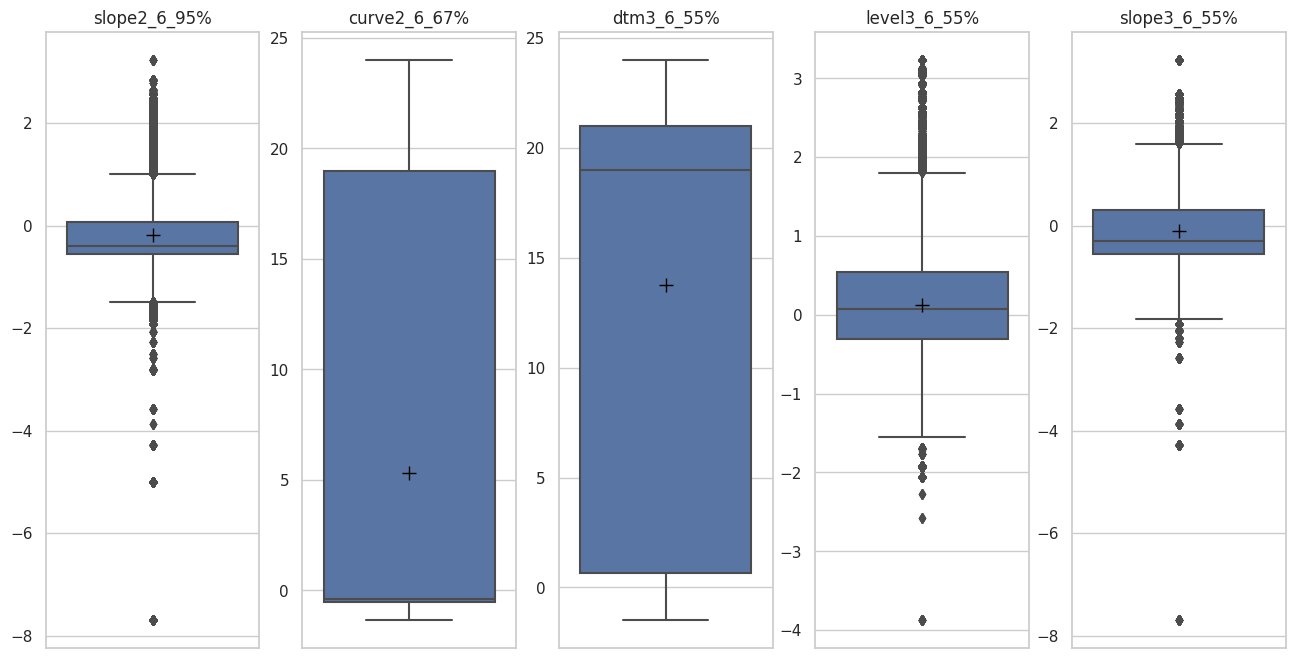

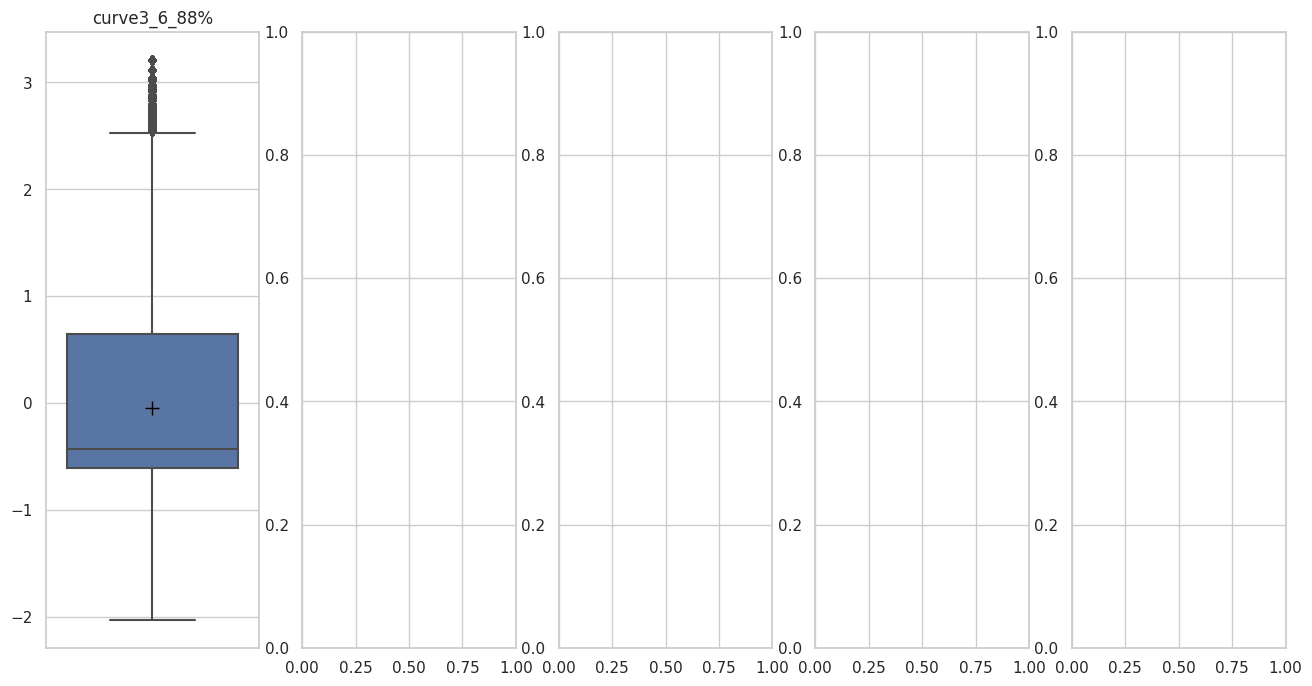

In [2]:
next_dep = 0
# next_dep=1
# next_dep=2
# next_dep=3
resume = True  # False#
# tables = ['volcva.csv']
tables = ['volcvn.csv','volcvt.csv','volcva.csv','volcvg.csv']
dfo = pd.DataFrame()
for table in tables:
    df = pd.read_csv(mydrive + table)
    dfo = pd.concat([dfo, df])

cont_names=[]
for var in vars_h:
    for i in range(duration):
        mvar = f'{var}_{i+1}'
        if not mvar in dfo.columns:
            dfo[mvar] = 0
        cont_names.append(mvar)

dfo.sort_values(by=['date'])
enc = OrdinalEncoder()
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')

print(dfo.shape, X_all.shape,len(dep_vars[0]))
zero_perc=(1-len(dfo[dfo['close']>0])/len(dfo)+len(dfo[dfo['close']<0])/len(dfo))/2
print(zero_perc,dfo['close'].quantile([0]+[i*(zero_perc-0.005)/9.5+0.005 for i in range(10)]+[0.995-(0.995-zero_perc)/10.5*(21-i) for i in range(11,22)]+[1]))
boxplot(vars_h[1:],bad_value)
boxplot([[f'{var}_{i+1}' for i in range(duration)] for var in vars_h[1:]],0)


In [3]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[dfo['spot']>15].iloc[0])

date                1.000000
Horizon             0.689260
spot               16.698330
dtm                -0.009540
level               6.000000
slope              -0.088530
curve               0.192480
dtm1                0.109350
level1             11.000000
slope1              0.007510
curve1              0.151630
dtm2               -0.005490
level2             16.000000
slope2              0.025560
curve2              0.093490
dtm3               -0.005640
level3          45112.663460
slope3          45113.663910
curve3          45114.665170
date_1          45117.656940
date_2          45118.401760
date_3          45119.663630
date_4             16.000000
date_5             15.000000
date_6             14.000000
diff_1             13.000000
diff_2             12.000000
diff_3             11.000000
diff_4              0.118490
diff_5              0.011730
diff_6              0.069280
hi                 13.000000
lo                  1.719230
close               1.767600
pmcat         

# run


Xcg_close,hi torch.Size([247117, 20])
PETrans 6 16 132 [] 40 2
loaded Xcg_close,hi epoch 82
offset  -68228
torch.Size([201400, 0]) torch.Size([201400, 22, 6]) torch.Size([201400, 20])
Xcg_close,hi 1.6231


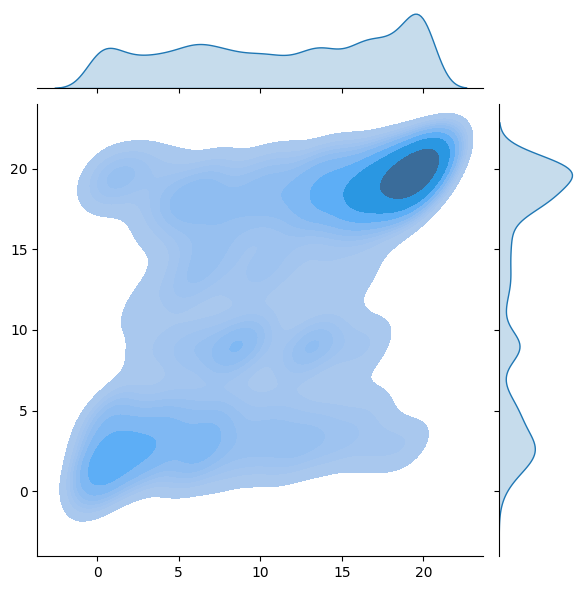

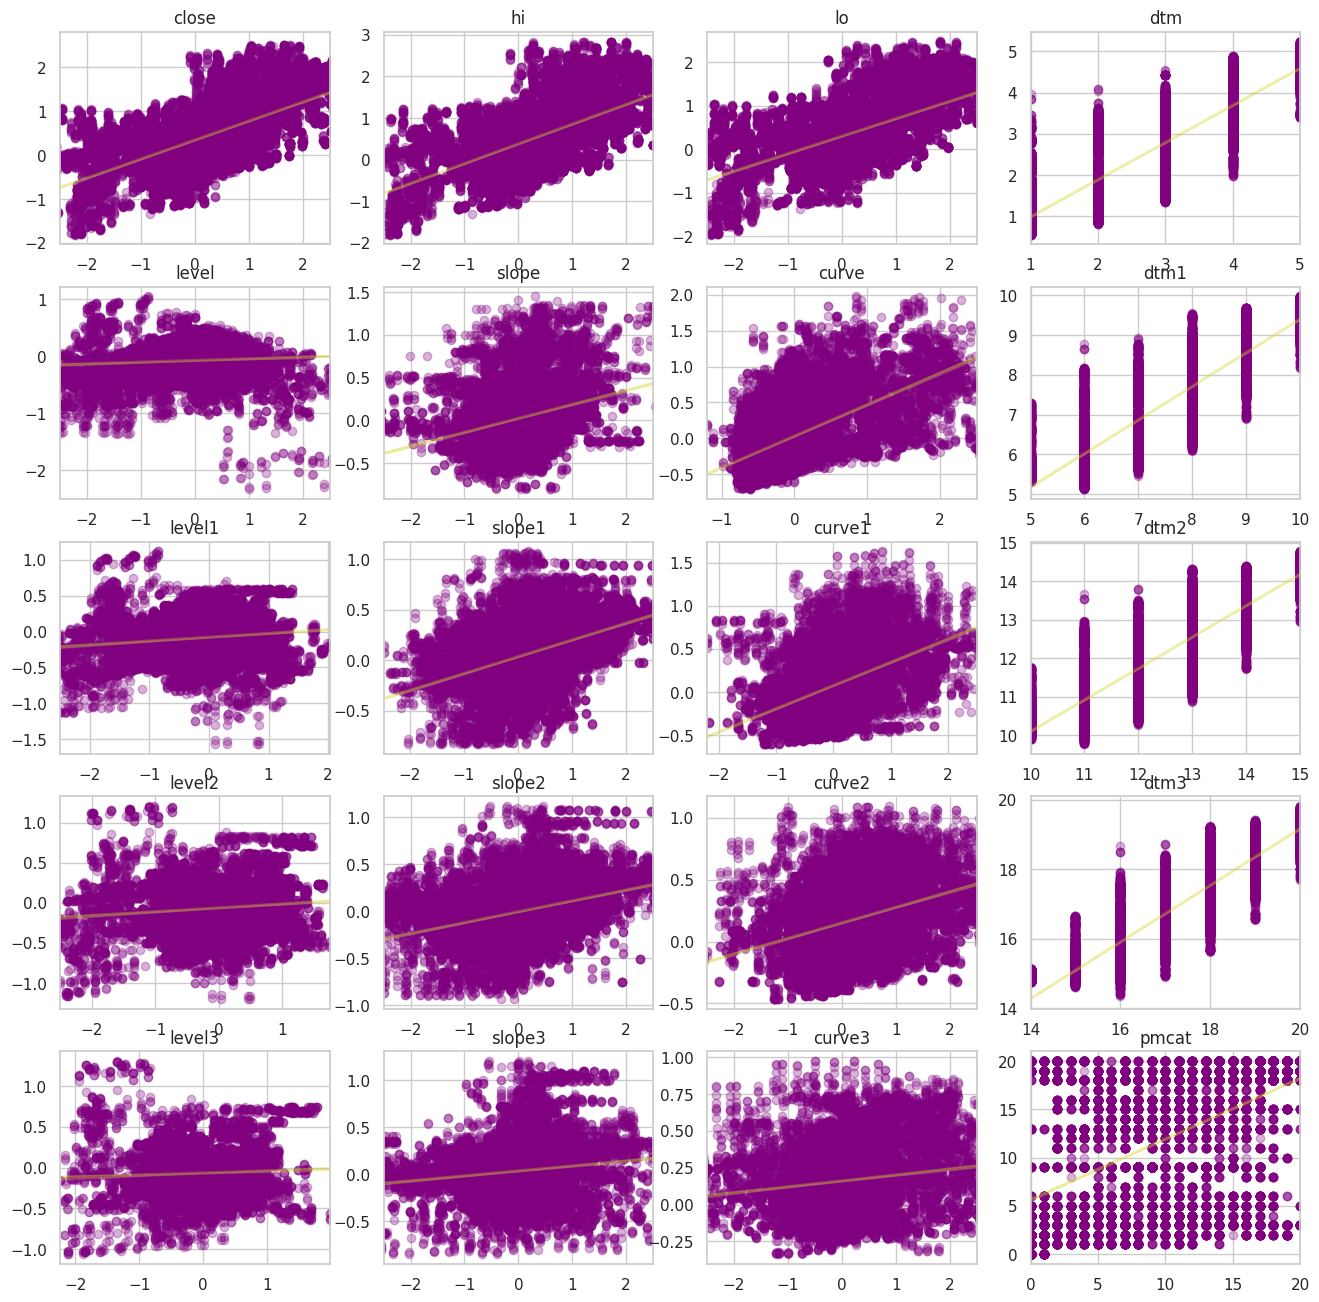

Epoch 082 | Validation score: 1.5635  <<< BEST VALIDATION EPOCH
Epoch 083 | Validation score: 1.5858  no improve 1
Epoch 084 | Validation score: 1.5903  no improve 2
Epoch 085 | Validation score: 1.5864  no improve 3
Epoch 086 | Validation score: 1.5664  no improve 4
Epoch 087 | Validation score: 1.5795  no improve 5
Epoch 088 | Validation score: 1.5757  no improve 6
Epoch 089 | Validation score: 1.5791  no improve 7
Epoch 090 | Validation score: 1.5603  <<< BEST VALIDATION EPOCH
Epoch 091 | Validation score: 1.5704  no improve 1
loaded Xcg_close,hi epoch 92
Epoch 092 | Validation score: 1.5781  no improve 2
Epoch 093 | Validation score: 1.5776  no improve 3
Epoch 094 | Validation score: 1.5900  no improve 4
Epoch 095 | Validation score: 1.5636  no improve 5
Epoch 096 | Validation score: 1.5558  <<< BEST VALIDATION EPOCH
Epoch 097 | Validation score: 1.5817  no improve 1
Epoch 098 | Validation score: 1.5583  no improve 2
Epoch 099 | Validation score: 1.5337  <<< BEST VALIDATION EPOCH
E

In [ ]:
# next_dep=0
# resume=False#s
# resume=True#False#
# ignore_load_error=True
# ignore_load_zero=True

n_epochs = 900
n_trials = 50
start_epoch = 1
sub_epochs=10

for dep_sec in range(next_dep, len(dep_vars)):
    n_no_improve = 0
    setup_data()
    print(X['train'][0].shape, X['train'][1].shape, y['train'].shape)
    validate()
    resume=True
    # report_frequency = len(X['train']) // batch_size // 5
    for epoc in range(start_epoch, n_epochs , sub_epochs):
      for epoch in range(epoc,epoc+sub_epochs):
        for iteration, batch_idx in enumerate(train_loader):
            my_model.train()
            optimizer.zero_grad()
            x_batch = (X['train'][0][batch_idx] if len(cat_names)>0 else None,
                       X['train'][1][batch_idx],
                       X['train'][2][batch_idx])
            y_batch = y['train'][batch_idx]
            loss = loss_fn(
                apply_model(my_model,
                            x_cat=x_batch[0] if len(cat_names)>0 else None,
                            x_num=x_batch[1], x2=x_batch[2]).squeeze(1),
                y_batch)
            loss.backward()
            optimizer.step()
            # if iteration % report_frequency == 0:
            #     print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

        val_score = evaluate()[0]
        # test_score = evaluate(my_model,'test')[0]
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f}', end=" ")
        progress.update(-val_score)
        if progress.success:
            print(' <<< BEST VALIDATION EPOCH')
            save_model(True)
            n_no_improve = 0
        else:
            save_model(False)
            n_no_improve += 1
            print(f' no improve {n_no_improve}')
        if progress.fail or val_score < .01 or n_no_improve > n_trials:
            break
      if progress.fail or val_score < .01 or n_no_improve > n_trials:
        break
      if n_no_improve<sub_epochs:
        load_model()
      else:
        print("noload",n_no_improve,sub_epochs)
    with open(mydrive + jobname, 'wb') as filehandler:
        dump((my_model, y_std, y_mean, enc), filehandler)
    validate()

## manual

In [ ]:

    # setup_data(0)
    prediction = []
    i=0
    with torch.no_grad():
      my_model.eval()
      for batch in zero.iter_batches(X['test'], batch_size):
      # batch=next(zero.iter_batches(X['test'], batch_size))
      # if True:
        prediction.append(apply_model(my_model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y['test']#[i:i+batch_size]
    if task_type == 'binclass':
      prediction = np.round(scipy.special.expit(prediction))
      score = sklearn.metrics.accuracy_score(target, prediction)
    elif task_type == 'multiclass':
      prediction = prediction.argmax(1)
      score = (target.reshape(-1)!=prediction).sum()/len(prediction)
    else:
      assert task_type == 'regression'
      score =mse_loss_with_nans(prediction, target, ) ** 0.5

    score,target, prediction


Xcf_dtm, lev torch.Size([231363, 16])
PETrans 6 16 132 [] 16 2
loaded Xcf_dtm, lev epoch 74
offset  -64321


(tensor(0.7848, device='cuda:0'),
 tensor([[ 4.0000e+00, -1.3228e-02, -1.0274e-01,  ...,  1.0533e-01,
           9.5372e-01,  2.4700e-01],
         [ 2.0000e+00,  1.2167e-01, -1.5562e-02,  ..., -7.9616e-02,
           9.9181e-03, -1.7748e-01],
         [ 1.0000e+00, -8.4570e-01,  3.6727e-01,  ..., -1.1988e-01,
          -1.0307e+00,  1.2879e+00],
         ...,
         [ 2.0000e+00, -2.0026e+00,  1.0725e+00,  ..., -6.1677e-01,
           2.8542e-03,  3.8150e-02],
         [ 4.0000e+00, -1.3515e-01, -4.9724e-01,  ..., -3.6680e-02,
          -2.7041e-01, -4.6244e-01],
         [ 4.0000e+00, -1.9064e+00,  1.9062e-02,  ..., -1.5916e+00,
          -8.3080e-01,  6.4188e-01]], device='cuda:0'),
 tensor([[ 3.6312,  0.2111, -0.2651,  ...,  0.0109,  0.1032,  0.4787],
         [ 1.0670,  0.5796, -0.1153,  ...,  0.1862, -0.2249, -0.0291],
         [ 0.9954, -0.9162, -0.0798,  ..., -0.5044, -0.1970,  0.4467],
         ...,
         [ 1.7209,  0.0851,  0.0357,  ...,  0.0411,  0.1121,  0.0917],
     

In [ ]:
for i in range(len(target)):
  if target[i][0]==1 and prediction[i][0]>2:
    print(i,target[i],prediction[i])

15382 tensor([ 1.0000e+00,  6.0205e-01, -4.2817e-01,  1.0109e+00,  5.0000e+00,
         4.9149e-01, -2.0451e-01, -4.4114e-01,  1.0000e+01,  1.5667e-01,
         2.5629e-01, -7.5276e-01,  1.5000e+01,  1.1539e-01, -9.2124e-01,
        -6.9835e-03], device='cuda:0') tensor([ 2.6289,  0.2052,  0.0468, -0.5407,  7.4679,  0.1687,  0.1701, -0.5982,
        12.2171,  0.0882,  0.0640, -0.2971, 16.9601,  0.0372,  0.1261, -0.1165],
       device='cuda:0')
18262 tensor([ 1.0000e+00,  3.3884e-02,  2.2153e-03, -5.6351e-01,  5.0000e+00,
         2.6321e-02, -6.4948e-01, -7.7102e-02,  1.0000e+01, -5.2886e-02,
        -4.5381e-01, -2.7395e-01,  1.5000e+01, -7.9756e-02, -5.3078e-01,
        -5.1002e-02], device='cuda:0') tensor([ 2.6289,  0.2052,  0.0468, -0.5407,  7.4679,  0.1687,  0.1701, -0.5982,
        12.2170,  0.0882,  0.0641, -0.2971, 16.9601,  0.0371,  0.1262, -0.1164],
       device='cuda:0')


In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[(dfo['dtm']==1)&(dfo['diff_1']==19)&(dfo['dtm_1']==10)&(dfo['Horizon']<4)].iloc[10])

date            #2022-10-06 10:29:58#
Horizon                             2
spot                         -0.94172
dtm                                 1
level                        -0.13269
slope                         1.34783
curve                         0.38551
dtm1                                6
level1                        0.06577
slope1                        0.27589
curve1                        0.10309
dtm2                               11
level2                        0.10553
slope2                         0.2063
curve2                        0.06762
dtm3                               16
level3                        0.09173
slope3                        0.19436
curve3                       -0.00611
date_1                    44827.66397
date_2                    44830.66464
date_3                    44833.57739
date_4                    44834.44378
date_5                     44837.3959
date_6                    44838.55333
diff_1                             19
diff_2      

Xcg_close,hi 9.4759


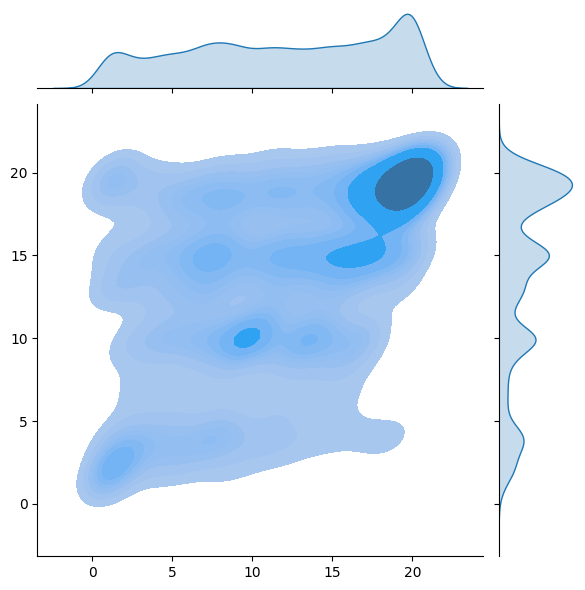

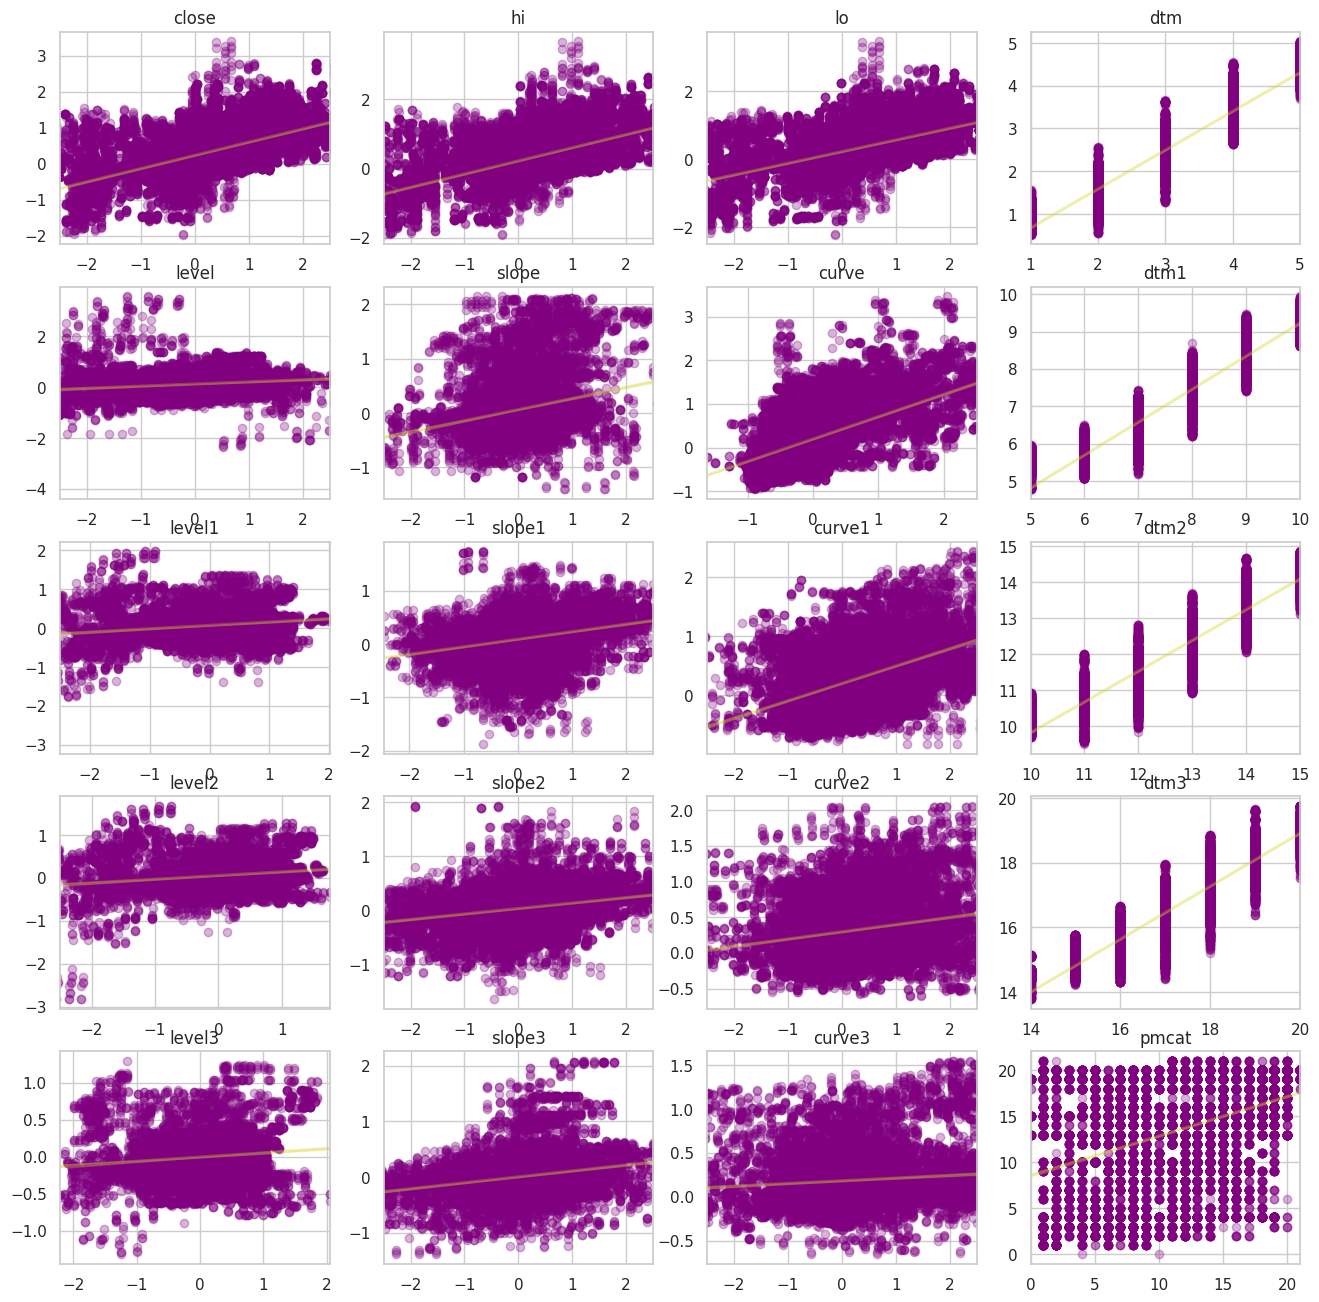

In [ ]:
validate()

In [ ]:
loss_fn=cross_entropy_mse_loss_with_nans
batch=next(zero.iter_batches(X['test'], batch_size))
p=apply_model(my_model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2])
loss = loss_fn(
                p.squeeze(1),
                y_batch)

## export

In [ ]:
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')
resume=True
ignore_load_zero=True
ignore_load_error=True

if len(dep_vars)>0:
  setup_data()
  with open(mydrive + jobname, 'wb') as filehandler:
      dump((my_model, y_std, y_mean, enc), filehandler)


Xcg_close,hi torch.Size([245882, 20])
PETrans 6 16 132 [] 41 2
loaded Xcg_close,hi epoch 260
offset  -68981


# valid

In [ ]:
last_run = "2023-08-30"
next_run = "2023-07-30"

models, cont_names = [], []
jobname = job_name()
with open(mydrive + jobname, 'rb') as filehandler:
    models.append(load(filehandler))

dfo = pd.DataFrame()
for table in tables:
    df = pd.read_csv(mydrive + table)
    df = df.query(f'date>"#{next_run}"')
    dfo = pd.concat([dfo, df])

for var in vars_h:
    for i in range(duration):
        mvar = f'{var}_{i+1}'
        if not mvar in dfo.columns:
            dfo[mvar] = 0
        cont_names.append(mvar)

enc=models[0][3]
dfo[cat_names] = enc.fit_transform(dfo[cat_names])

def val_period():
    global jobname, X, y, my_model, y_mean, y_std
    for period in [[last_run, '9999'], [next_run, last_run]]:
        print(period)
        df = dfo.query(f'date>"#{period[0]}" and date<"#{period[1]}"')
        dep_var=dep_vars[0]+dep_vars[1]
        X, y = ({'test':
                 (  # dfo.loc[:,cat_names+vars_c+cont_names].to_numpy().astype('float32')},{}
                     torch.tensor(df.loc[:, cat_names].to_numpy(), device=device).to(torch.int64),
                     torch.tensor(df.loc[:, cont_names].to_numpy().astype('float32').reshape((df.shape[0], int(len(cont_names) / duration), duration)), device=device),
                     torch.tensor(df.loc[:, vars_c].to_numpy().astype('float32'), device=device),
                 )
                 }, {'test': torch.tensor(df.loc[:,dep_var].to_numpy(), device=device).float()})
        print('duration: ', duration,df.shape, X['test'][0].shape, X['test'][1].shape, X['test'][2].shape)
        y['test'][:,-1]-=1

        for learner in models:
            jobname = job_name()
            my_model, y_std, y_mean, enc = learner
            y['test'][y['test']==bad_value]=float('nan')
            cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
            y['test'][:,cols_to_norm]=((y['test']-y_mean) / y_std)[:,cols_to_norm].float()
            validate()

['2023-08-30', '9999']
duration:  6 (6772, 156) torch.Size([6772, 0]) torch.Size([6772, 22, 6]) torch.Size([6772, 2])
Xcg_close,hi 5.8685


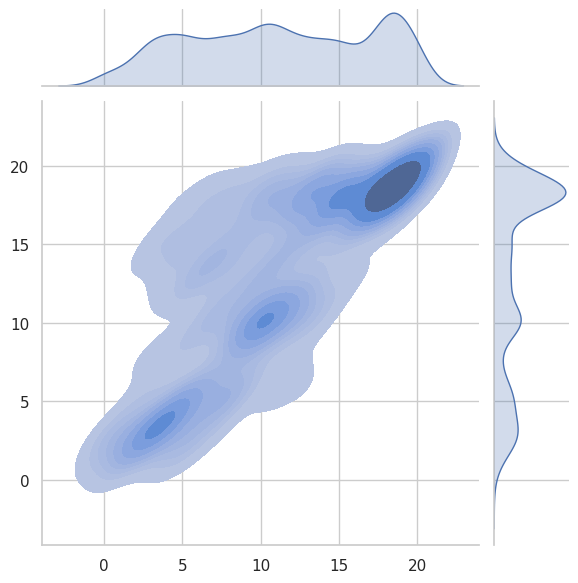

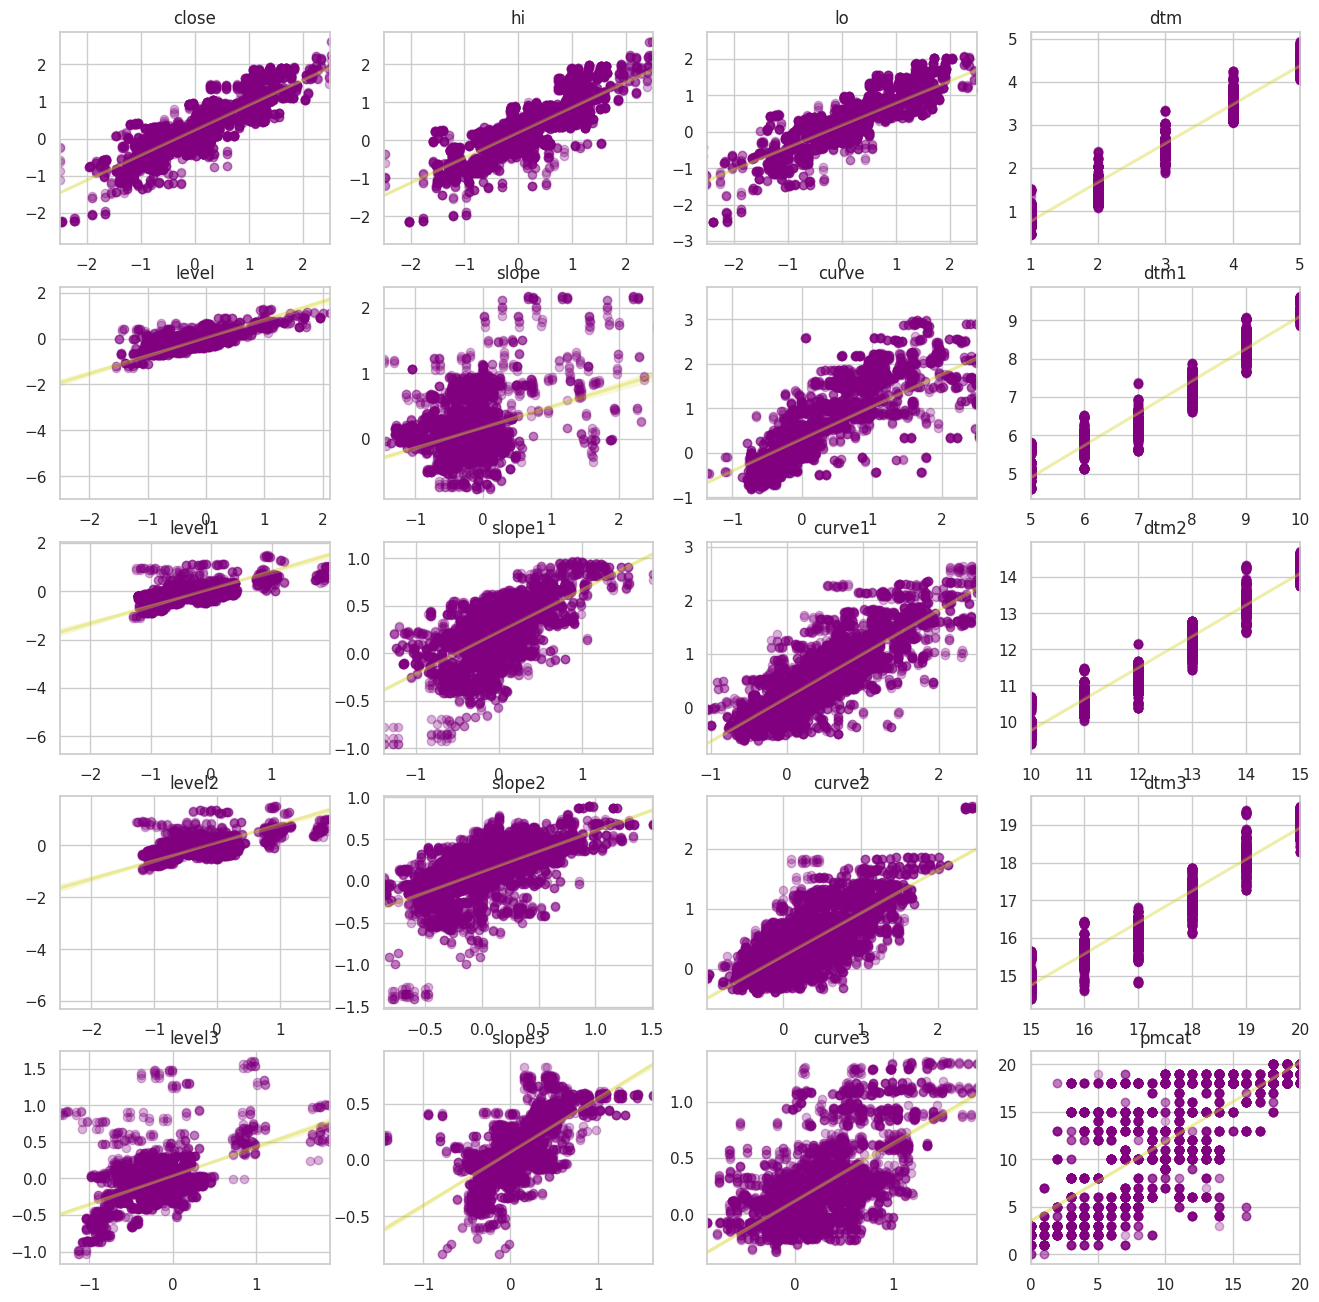

['2023-07-30', '2023-08-30']
duration:  6 (15060, 156) torch.Size([15060, 0]) torch.Size([15060, 22, 6]) torch.Size([15060, 2])
Xcg_close,hi 6.4102


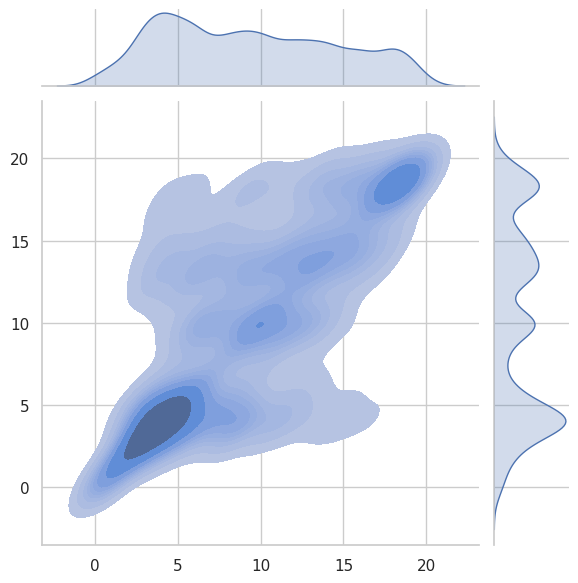

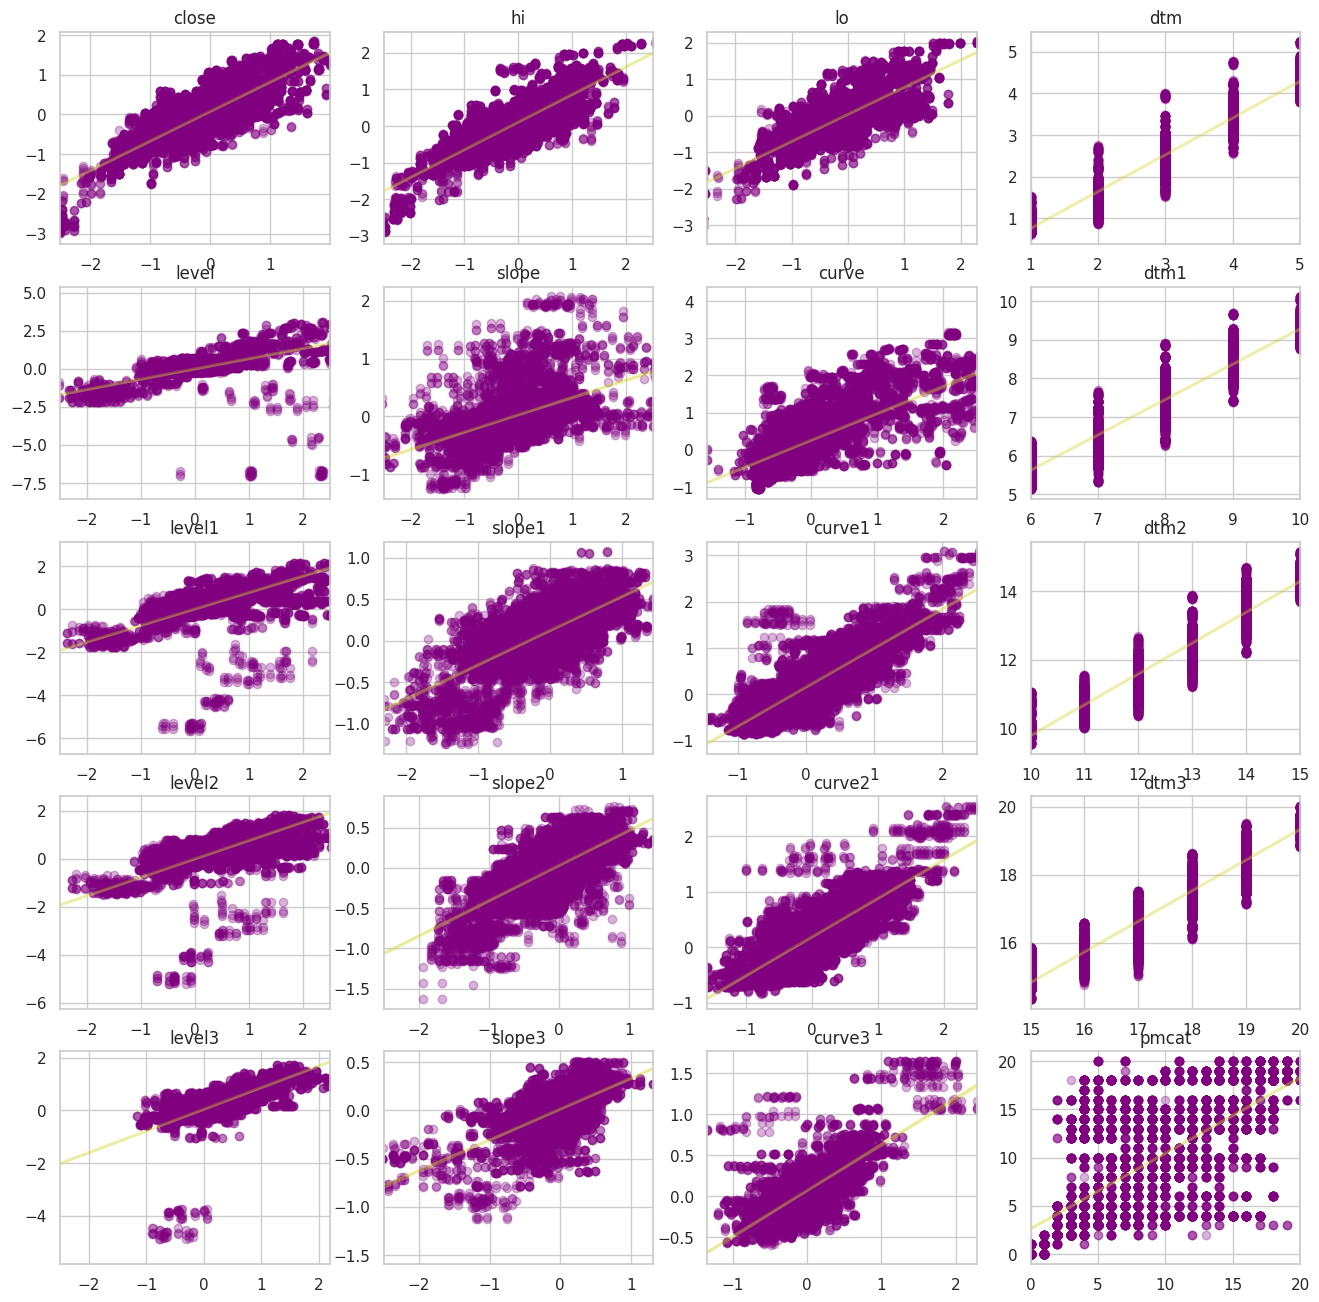

In [ ]:
val_period()

## after

In [ ]:
val_period()

# all

Mounted at /content/drive
  Cloning https://github.com/jerronl/rtdl.git to /tmp/pip-req-build-thcxrq5p
  Running command git clone --filter=blob:none --quiet https://github.com/jerronl/rtdl.git /tmp/pip-req-build-thcxrq5p
  Resolved https://github.com/jerronl/rtdl.git to commit f98ce61e5574c18e249a21e417e208f4832de808
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for rtdl: filename=rtdl-0.0.14.dev0-py3-none-any.whl size=77961 sha256=25a28b29d6118b77f5bc47797eb4ceaa74880b91a813367467dd542c65772c45
  Stored in directory: /tmp/pip-ephem-wheel-cache-xh1b_r9c/wheels/8d/92/7b/32aaeaca71d3de56c377bd2561972e24497e709ff9f9d967cc
Successfully built rtdl
GPU mem:16G, batch_size:192
(261601, 156) (261601, 134) 19
0.4607417402838674 0.000000   -1.795600
0.005000   -1.049730
0.052973   -0.582740
0.100946   -0.400276
0.148918   -0.291400
0.196891   -0.224840
0.244864   -0.165746
0.292837   -0.1183

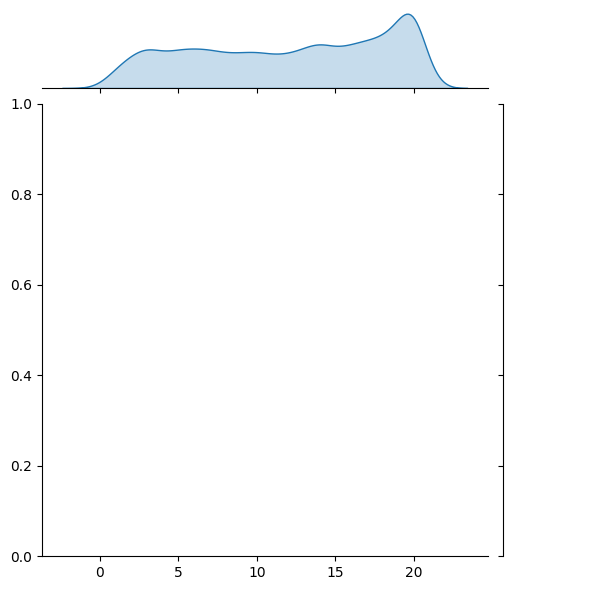

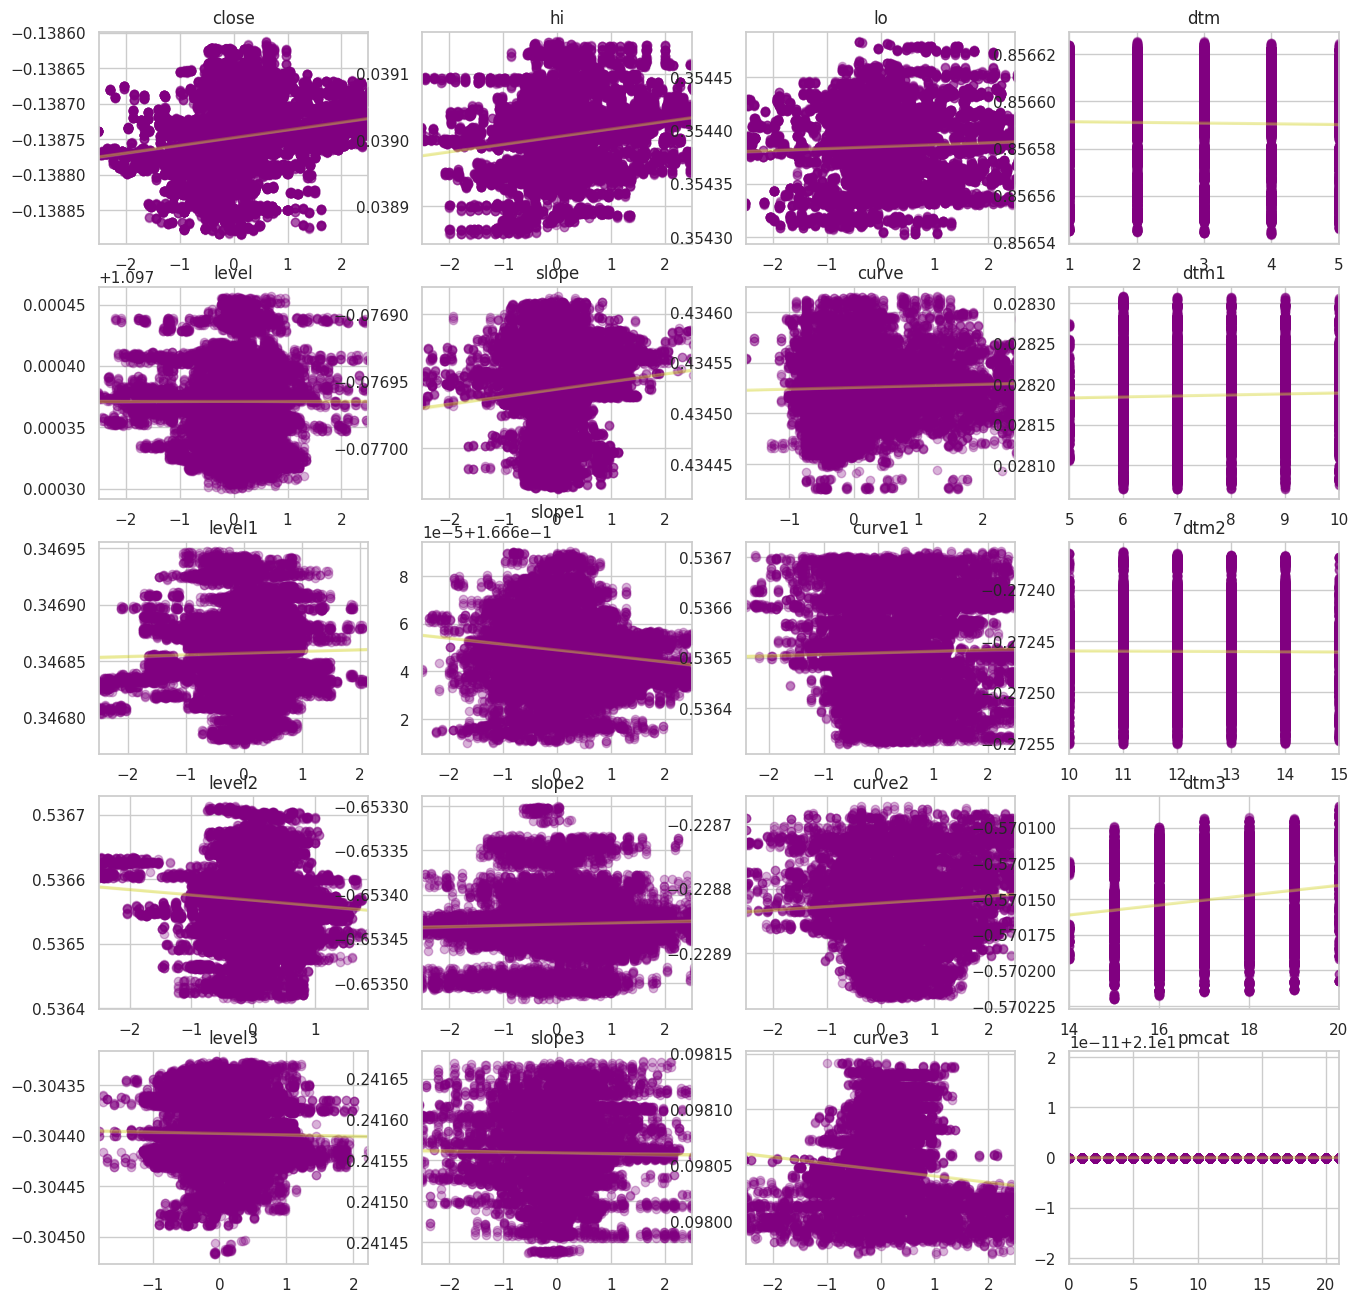

Epoch 001 | Validation score: 12.1138  <<< BEST VALIDATION EPOCH
Epoch 002 | Validation score: 11.7966  <<< BEST VALIDATION EPOCH
Epoch 003 | Validation score: 11.4670  <<< BEST VALIDATION EPOCH
Epoch 004 | Validation score: 11.1499  <<< BEST VALIDATION EPOCH
Epoch 005 | Validation score: 10.6554  <<< BEST VALIDATION EPOCH
Epoch 006 | Validation score: 10.2944  <<< BEST VALIDATION EPOCH
Epoch 007 | Validation score: 10.0929  <<< BEST VALIDATION EPOCH
Epoch 008 | Validation score: 10.1323  no improve 1
Epoch 009 | Validation score: 9.9259  <<< BEST VALIDATION EPOCH
Epoch 010 | Validation score: 9.8611  <<< BEST VALIDATION EPOCH
loaded Xch_close,hi epoch 11
Epoch 011 | Validation score: 9.6148  <<< BEST VALIDATION EPOCH
Epoch 012 | Validation score: 9.7611  no improve 1
Epoch 013 | Validation score: 9.6472  no improve 2
Epoch 014 | Validation score: 9.5067  <<< BEST VALIDATION EPOCH
Epoch 015 | Validation score: 9.4425  <<< BEST VALIDATION EPOCH
Epoch 016 | Validation score: 9.7126  no i

In [ ]:
tables = ['volc.csv']
mydrive= 'E:/mydoc/git/trade/analyics/'
# """
tables = ['volcvn.csv','volcvt.csv','volcva.csv','volcvg.csv']
from google.colab import drive
drive.mount('/content/drive')
mydrive='/content/drive/MyDrive/volrt/'
# Requirements:
%pip install git+https://github.com/jerronl/rtdl.git
#"""

appname='Xch_'
duration = 6
bad_value=-99999
vars_h, cat_names, ys,vars_c,= (
    ['date', 'diff', 'spot'],
    [],
    [[
        'close', 'hi', 'lo',
        'dtm','level','slope','curve',
         'dtm1','level1','slope1','curve1',
         'dtm2','level2','slope2','curve2',
         'dtm3','level3','slope3','curve3'],
         [ 'pmcat',],],
    ['Horizon','spot'],
)
import numpy as np

vars_h+=ys[0]
dep_vars=ys#[duration]
# vars_c=vars_c[duration]

ignore_load_zero=ignore_load_error=y_std=y_mean=X=y=loss_fn=my_model=jobsize=offset=start_epoch=optimizer = None

import warnings
warnings.filterwarnings('ignore')
from typing import Any, Dict
import rtdl
import scipy.special
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import rtdl.zero as zero
import matplotlib.pyplot as plt,os
%matplotlib inline
from typing import Optional
from torch import Tensor
import torch.nn as nn
import math
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from pickle import dump, load
import seaborn as sns
import random
from datetime import datetime

# !pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.13-cp38-cp38-linux_x86_64.whl --force-reinstall
# import torch_xla
# import torch_xla.core.xla_model as xm
# device = xm.xla_device()

device = torch.device('cuda')
zero.improve_reproducibility(seed=1234567)
batch_size=int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)*12
print(f'GPU mem:{int(torch.cuda.get_device_properties(0).total_memory/1e9+.5)}G, batch_size:{batch_size}')

################################################## model ############################
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000, position=None):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        if position is None:
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x
class PETrans(nn.Module):

    def __init__(self, duration, d_model,n_num_features,cat_cardinalities,d_out,x2):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        print("PETrans",duration, d_model,n_num_features,cat_cardinalities,d_out,x2)
        super().__init__()
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Linear(duration, d_model*2), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Dropout(0.1), #self.hparams.input_dropout),
            nn.GELU(), # self.hparams.input_dim, self.hparams.model_dim)
            nn.Linear(d_model*2, d_model), # self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=d_model)
        self.unf=nn.Flatten(1,2)
        self.ftt= rtdl.FTTransformer.make_default(
            n_num_features=int(n_num_features/duration*d_model+x2),
            cat_cardinalities=cat_cardinalities,
            d_out=d_out,
            )

    def forward(self, x_num: Optional[Tensor], x_cat: Optional[Tensor], x2: Optional[Tensor]) -> Tensor:
        x = self.input_net(x_num)
        x = self.positional_encoding(x)
        x = self.unf(x)
        x = torch.cat((x, x2), 1)
        x = self.ftt(x, x_cat)
        return x

    def make_default_optimizer(self) -> torch.optim.AdamW:
        """Make the optimizer for the default FT-Transformer."""
        return self.ftt.make_default_optimizer()

def apply_model(model, x_num, x_cat=None, x2=None):
    return model(x_num, x_cat, x2)

@torch.no_grad()
def evaluate(mload=None,part='val'):
    model=mload or my_model
    model.eval()
    prediction = []
    for batch in zero.iter_batches(X[part], batch_size):
        prediction.append(apply_model(model,
                                      x_cat=batch[0] if len(cat_names)>0 else None,
                                      x_num=batch[1],x2=batch[2]))
    prediction = torch.cat(prediction)
    target = y[part]
    prediction2 = prediction[:,-y_cat:].argmax(1)
    mask = ~torch.isnan(target[:,:-1])
    score = (F.mse_loss(prediction[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
          ((target[:,-1]!=prediction2).sum()/len(prediction))

    return score,target, prediction,prediction2

@torch.no_grad()
def validate(mload=None):
  score,target, prediction,prediction2 = evaluate(mload,'test')
  print(jobname,f'{score:.4f}')
  target, prediction, prediction2 = target.squeeze(1).cpu().numpy(), prediction.squeeze(1).cpu().numpy(), prediction2.cpu().numpy()
  sns.jointplot(x=target[:,-1] , y=prediction2,kind="kde",fill=True,rug=True)
  prediction[:,-y_cat]=prediction2
  sns.set(style="whitegrid")
  dep_var=dep_vars[0]+dep_vars[1]
  figs=min(len(dep_var),4)
  _, axes = plt.subplots(math.ceil(len(dep_var)/figs), figs, figsize=(16,16))
  for i,name in enumerate(dep_var):
      axs=axes.flat[i] if figs>1 else axes
      sns.regplot(ax=axs, x=target[:,i] , y=prediction[:,i],
                scatter_kws = {'color': 'purple', 'alpha': 0.3},
                line_kws = {'color': '#CCCC00', 'alpha': 0.3}
                )
      axs.set_title(name)
      mask=~np.isnan(target[:,i])
      if not dep_var[i][:3] in ['dtm','pmc']:
        axs.set_xlim(left=max(np.min(target[:,i][mask]), -2.5),
                      right=min(np.max(target[:,i][mask]),2.5))
      else:
        axs.set_xlim(left=np.min(target[:,i][mask]),
                            right=np.max(target[:,i][mask]))
  plt.show()

def cross_entropy_mse_loss_with_nans(input, target):
    mask = ~torch.isnan(target[:,:-1])
    return (F.mse_loss(input[:,:-y_cat][mask],target[:,:-1][mask])**.5)*10+\
      (F.cross_entropy (input[:,-y_cat:],target[:,-1].type(torch.LongTensor).to(device)))

def model_path():
  return mydrive+jobname+'checkpoint.pt'

def save_model(improved=False):
  path=mydrive+jobname+'checkpoint.pt'
  torch.save(
      {
          'model':  my_model.state_dict() if improved or not os.path.exists(path) else #else #
                    torch.load(path)['model'],
          'optimizer': optimizer.state_dict(),
          'epoch': epoch,
          'random_state': zero.random.get_state (),
          'jobsize': jobsize,
          'offset': offset,
      },
      path
  )

def load_model():
  global jobsize,offset,start_epoch,my_model,optimizer
  start_epoch=1
  jobsize=int(len(X_all)*0.1)
  if resume:
    path=mydrive+jobname+'checkpoint.pt'
    if os.path.exists(path):
      try:
        checkpoint = torch.load(path,map_location=device)
        my_model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        try:
          zero.random.set_state(checkpoint['random_state'])
        except (AssertionError,) as err:
          if ignore_load_zero:
            print("zero error:",err)
          else:
            raise err
        print(f'loaded {jobname} epoch {start_epoch}')
        if 'jobsize' in checkpoint and checkpoint['jobsize']==jobsize:
          offset=checkpoint['offset']
        else:
          raise ValueError('size diffs now',jobsize,
                checkpoint['jobsize'] if 'jobsize' in checkpoint else 0)
        return True
      except Exception as error:
        if ignore_load_error:
          print("failed to load: ", error)
        else:
          raise error
  random.seed(datetime.now().timestamp())
  offset=random.randint(-jobsize*3,-jobsize*2)
  return False

def job_name():
  return appname+''.join(filter(lambda x: x not in "[' ", str(dep_vars[0])))[:8]

def setup_data():
  global jobname,X,y, my_model,optimizer,train_loader,progress,y_mean,y_std,loss_fn,y_cat
  dep_var=dep_vars[0]+dep_vars[1]
  jobname=job_name()
  y_all=torch.tensor(dfo.loc[:,dep_var].to_numpy(), device=device)

  y_cat = int(max(y_all[:,-1]))
  y_all[:,-1]-=1
  d_out = y_cat+y_all.shape[1]-1
  print(jobname,y_all.shape)

  X,y = {},{}
  my_model=PETrans(
      duration=duration,
      d_model=16,
      n_num_features=len(cont_names),
      cat_cardinalities=[len(arr) for arr in enc.categories_],
      d_out=d_out,
      x2=len(vars_c)
      ).to(device)

  optimizer = (
      my_model.make_default_optimizer()
  )
  load_model()
  print('offset ',offset)
  X['train'], X['test'], y['train'], y['test']  = (
      np.concatenate((X_all[:offset],X_all[offset+jobsize:])),
      X_all[offset:offset+jobsize],
      torch.cat((y_all[:offset],y_all[offset+jobsize:])),
      y_all[offset:offset+jobsize],
  )
  X['train'], X['val'],  y['train'], y['val']  = sklearn.model_selection.train_test_split(
      X['train'], y['train'], train_size=0.9
  )
  X2, X['test'], y2, y['test']  = sklearn.model_selection.train_test_split(
      X['test'], y['test'], train_size=0.05
  )
  X['val'], y['val']=np.concatenate((X['val'], X['test'])),torch.cat(( y['val'], y['test']))
  X['train'], y['train']=np.concatenate((X['train'], X2)),torch.cat(( y['train'], y2))

  X = {
      k: (torch.tensor(v[:,:len(cat_names)], device=device).to(torch.int64),
          torch.tensor(v[:,-len(cont_names):].reshape((v.shape[0],int(len(cont_names)/duration),duration)), device=device),
          torch.tensor(v[:,len(cat_names):-len(cont_names)], device=device),)
      for k, v in X.items()
  }
  # y = {k: torch.tensor(v, device=device) for k, v in y.items()}
  mask=torch.masked.masked_tensor(y['train'],y['train']!=bad_value)
  y_mean,y_std=mask.mean(dim=0).to_tensor(0),mask.std(dim=0).to_tensor(0)
  cols_to_norm=[i for i in range(len(dep_var)) if not dep_var[i][:3] in ['dtm','pmc']]
  for k,v in y.items():
    v[v==bad_value]=float('nan')
    v[:,cols_to_norm]=((v-y_mean) / y_std)[:,cols_to_norm]
    y[k]=v


  y = {k: v.float() for k, v in y.items()}

  train_loader = zero.data.IndexLoader(len(X['train'][0]), batch_size, device=device)
  progress = zero.ProgressTracker(patience=100)
  loss_fn = cross_entropy_mse_loss_with_nans

def boxplot(vars,bad_value=None):
  i=j=min(5,len(vars))
  for _,var in enumerate(vars):
      if isinstance(var,list):
        y=pd.Series()
        for name in var:
          if name in dfo.columns:
            y=y.append(dfo[name],ignore_index = True)
      else:
        y=dfo[var] if var in dfo.columns else []
        name=var
      if len(y)>0:
        if i>=j:
          figure, axes = plt.subplots(1,j,figsize=(16,8))
          i=0
        axs=axes.flat[i]
        i+=1
        if bad_value is not None and y.min()<=bad_value:
          mask=y!=bad_value
          name=f'{name}_{mask.sum()/len(mask):.0%}'
          y=y[mask]
        sns.boxplot(ax=axs, y=y, showmeans=True,
                          meanprops={"marker": "+",
                        "markeredgecolor": "black",
                        "markersize": "10"})
        axs.set_title(name)
  plt.show()


def set_state(state: Dict[str, Any]) -> None:
    """Set global random states in `random`, `numpy` and `torch`.

    Args:
        state: global RNG states. Must be produced by `get_state`. The size of the list
            :code:`state['torch.cuda']` must be equal to the number of available cuda
            devices.

    See also:
        `get_state`

    Raises:
        AssertionError: if :code:`torch.cuda.device_count() != len(state['torch.cuda'])`
    """
    random.setstate(state['random'])
    np.random.set_state(state['numpy.random'])
    torch.random.set_rng_state(state['torch.random'].cpu())
    assert torch.cuda.device_count() == len(state['torch.cuda'])
    torch.cuda.set_rng_state_all([v.cpu() for v in state['torch.cuda']])  # type: ignore

zero.random.set_state=set_state
############################################## train ##########################################
next_dep = 0
# next_dep=1
# next_dep=2
# next_dep=3
resume = True  # False#
# batch_size = 256
# tables = ['volcva.csv']

dfo = pd.DataFrame()
for table in tables:
    df = pd.read_csv(mydrive + table)
    dfo = pd.concat([dfo, df])

cont_names=[]
for var in vars_h:
    for i in range(duration):
        mvar = f'{var}_{i+1}'
        if not mvar in dfo.columns:
            dfo[mvar] = 0
        cont_names.append(mvar)

dfo.sort_values(by=['date'])
enc = OrdinalEncoder()
dfo[cat_names] = enc.fit_transform(dfo[cat_names])
X_all = dfo.loc[:, cat_names + vars_c + cont_names].to_numpy().astype('float32')

print(dfo.shape, X_all.shape,len(dep_vars[0]))
zero_perc=(1-len(dfo[dfo['close']>0])/len(dfo)+len(dfo[dfo['close']<0])/len(dfo))/2
print(zero_perc,dfo['close'].quantile([0]+[i*(zero_perc-0.005)/9.5+0.005 for i in range(10)]+[0.995-(0.995-zero_perc)/10.5*(21-i) for i in range(11,22)]+[1]))
# boxplot(vars_h[1:],bad_value)
# boxplot([[f'{var}_{i+1}' for i in range(duration)] for var in vars_h[1:]],0)
# next_dep=0
# resume=False#s
# resume=True#False#
# ignore_load_error=True
# ignore_load_zero=True

############################################## run ##########################################
n_epochs = 900
n_trials = 50
start_epoch = 1
sub_epochs=10

for dep_sec in range(next_dep, len(dep_vars)):
    n_no_improve = 0
    setup_data()
    print(X['train'][0].shape, X['train'][1].shape, y['train'].shape)
    validate()
    resume=True
    # report_frequency = len(X['train']) // batch_size // 5
    for epoc in range(start_epoch, n_epochs , sub_epochs):
      for epoch in range(epoc,epoc+sub_epochs):
        for iteration, batch_idx in enumerate(train_loader):
            my_model.train()
            optimizer.zero_grad()
            x_batch = (X['train'][0][batch_idx] if len(cat_names)>0 else None,
                       X['train'][1][batch_idx],
                       X['train'][2][batch_idx])
            y_batch = y['train'][batch_idx]
            loss = loss_fn(
                apply_model(my_model,
                            x_cat=x_batch[0] if len(cat_names)>0 else None,
                            x_num=x_batch[1], x2=x_batch[2]).squeeze(1),
                y_batch)
            loss.backward()
            optimizer.step()
            # if iteration % report_frequency == 0:
            #     print(f'(epoch) {epoch} (batch) {iteration} (loss) {loss.item():.4f}')

        val_score = evaluate()[0]
        # test_score = evaluate(my_model,'test')[0]
        print(f'Epoch {epoch:03d} | Validation score: {val_score:.4f}', end=" ")
        progress.update(-val_score)
        if progress.success:
            print(' <<< BEST VALIDATION EPOCH')
            save_model(True)
            n_no_improve = 0
        else:
            save_model(False)
            n_no_improve += 1
            print(f' no improve {n_no_improve}')
        if progress.fail or val_score < .01 or n_no_improve > n_trials:
            break
      if progress.fail or val_score < .01 or n_no_improve > n_trials:
        break
      if n_no_improve<sub_epochs:
        load_model()
      else:
        print("noload",n_no_improve,sub_epochs)
    with open(mydrive + jobname, 'wb') as filehandler:
        dump((my_model, y_std, y_mean, enc), filehandler)
    validate()

# end

In [ ]:
X['test'][0][mini],X['test'][1][mini],X['test'][2][mini]


Xcc_close, h torch.Size([65185, 3])
PETrans 5 16 110 [8] 3 0
loaded Xcc_close, h epoch 357
offset  -15178


In [ ]:
print(f"date_1:{X['test'][1][mini][0][0]} dtm:{target[mini][0]} diff_1:{X['test'][1][mini][1][0]} dtm_1:{X['test'][1][mini][6][0]}Horizon:{X['test'][2][mini][0]}")
dfo[(dfo['dtm']==int(target[mini][0]))&(dfo['date_1']>=int(X['test'][1][mini][0][0]*100-.5)/100.)&(dfo['date_1']<=int(X['test'][1][mini][0][0]*100+1)/100.)&(dfo['diff_1']==int(X['test'][1][mini][1][0]))&(dfo['dtm_1']==int(X['test'][1][mini][6][0]))&(dfo['Horizon']==int(X['test'][2][mini][0]))]

tensor([ 0.0597,  0.1795, -0.0806], device='cuda:0', dtype=torch.float64)

In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[(dfo['dtm']==int(target[mini][0]))&(dfo['date_1']>=int(X['test'][1][mini][0][0]*100-.5)/100.)&(dfo['date_1']<=int(X['test'][1][mini][0][0]*100+1)/100.)&(dfo['diff_1']==int(X['test'][1][mini][1][0]))&(dfo['dtm_1']==int(X['test'][1][mini][6][0]))&(dfo['Horizon']==int(X['test'][2][mini][0]))].iloc[10])

In [ ]:
y['test']

tensor([[ 1.4684e+00,  1.8226e+00,  1.3640e+00,  ..., -9.9999e+04,
         -9.9999e+04,  2.0000e+01],
        [-6.2687e-01,  2.3860e-02, -6.4011e-01,  ..., -2.4437e-01,
         -1.4853e-01,  1.0000e+00],
        [ 1.8294e-01,  4.4767e-01,  1.0860e-02,  ..., -9.9999e+04,
         -9.9999e+04,  1.4000e+01],
        ...,
        [ 2.8748e-01,  4.4985e-01,  1.5132e-01,  ..., -3.5910e-02,
          7.1900e-03,  1.6000e+01],
        [-1.1756e-01,  9.0040e-02, -1.3910e-01,  ..., -9.9999e+04,
         -9.9999e+04,  6.0000e+00],
        [-2.3524e-01,  9.0840e-02, -2.4515e-01,  ..., -6.7920e-02,
         -1.7040e-02,  4.0000e+00]], device='cuda:0')

<Axes: xlabel='close', ylabel='Count'>

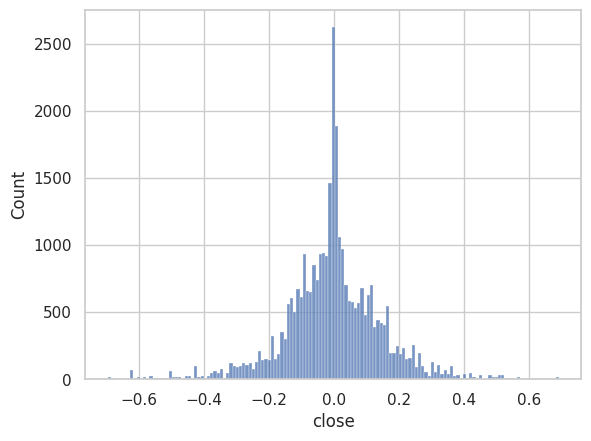

In [ ]:
sns.histplot( dfo[(dfo['Horizon']==0)]['close'])

In [ ]:
dfo[(dfo['Horizon']==0)&(dfo['close']<-0.67)]

date  Horizon     spot  dtm    level    slope  \
31239  #2022-08-26 09:31:40#        0 -0.12284    5  0.00019 -0.00030   
31240  #2022-08-26 15:59:11#        0 -0.81006    5  0.65011  0.68597   
31256  #2022-08-26 09:31:40#        0 -0.12280    5  0.00020  0.00035   
31257  #2022-08-26 15:59:11#        0 -0.80945    5  0.65020  0.68595   
31273  #2022-08-26 09:31:40#        0 -0.12278    5 -0.00003 -0.00046   
31274  #2022-08-26 15:59:11#        0 -0.80977    5  0.65012  0.68601   
87087  #2023-06-21 09:32:04#        0  3.48904    2  0.00006  0.00060   
87088  #2023-06-21 09:55:31#        0  3.28216    2 -0.24291  0.63467   
87089  #2023-06-21 11:50:15#        0  3.04917    2  0.14384  0.76397   
87090  #2023-06-21 13:25:40#        0  2.79858    2  0.16215  0.29999   
87091  #2023-06-21 15:57:26#        0  2.79904    2  0.38680 -0.64284   
87113  #2023-06-21 09:32:04#        0  3.48607    2 -0.00004  0.00048   
87114  #2023-06-21 09:55:31#        0  3.28150    2 -0.24260  0.63511   
87115  #2023-06-21 11:50:15#        0  3.04859    2  0.14384  0.76317   
87116  #2023-06-21 13:25:40#        0  2.79806    2  0.16216  0.30069   
87117  #2023-06-21 15:57:26#        0  2.79738    2  0.38669 -0.64322   
87139  #2023-06-21 09:32:04#        0  3.48645    2 -0.00001  0.00025   
87140  #2023-06-21 09:55:31#        0  3.28030    2 -0.24258  0.63346   
87141  #2023-06-21 11:50:15#        0  3.04855    2  0.14384  0.76364   
87142  #2023-06-21 13:25:40#        0  2.79910    2  0.16214  0.30002   
87143  #2023-06-21 15:57:26#        0  2.79805    2  0.38688 -0.64340   

         curve  dtm1   level1   slope1  ...     lo_5  close_1  close_2  \
31239  0.00005     9 -0.00012  0.00003  ... -0.56370 -0.13198 -0.47832   
31240 -0.16049     9  0.63709 -0.44917  ... -0.56373 -0.13197 -0.47833   
31256 -0.00007     9 -0.00023  0.00002  ... -0.56377 -0.13198 -0.47832   
31257 -0.16052     9  0.63718 -0.44921  ... -0.56368 -0.13198 -0.47830   
31273 -0.00010     9 -0.00004 -0.00010  ... -0.56369 -0.13197 -0.47832   
31274 -0.16053     9  0.63711 -0.44940  ... -0.56378 -0.13198 -0.47833   
87087 -0.00010     7 -0.00001 -0.00022  ...  2.85935  2.76022  2.68130   
87088  0.15750     7 -0.07447  0.13387  ...  2.85952  2.76005  2.68152   
87089 -0.05812     7  0.19001  0.18629  ...  2.85945  2.76012  2.68117   
87090  0.18649     7  0.19134  0.01365  ...  2.85945  2.76012  2.68126   
87091  0.60475     7  0.18555 -0.31413  ...  2.85940  2.76028  2.68148   
87113 -0.00031     7  0.00001 -0.00034  ...  2.85908  2.76019  2.68138   
87114  0.15790     7 -0.07451  0.13417  ...  2.85939  2.75996  2.68146   
87115 -0.05786     7  0.19008  0.18656  ...  2.85960  2.76010  2.68129   
87116  0.18675     7  0.19146  0.01298  ...  2.85946  2.76003  2.68138   
87117  0.60458     7  0.18565 -0.31411  ...  2.85930  2.76038  2.68127   
87139  0.00003     7  0.00001  0.00059  ...  2.85948  2.76047  2.68129   
87140  0.15721     7 -0.07445  0.13434  ...  2.85928  2.76049  2.68114   
87141 -0.05784     7  0.18995  0.18616  ...  2.85936  2.76037  2.68146   
87142  0.18645     7  0.19135  0.01336  ...  2.85942  2.76031  2.68120   
87143  0.60495     7  0.18554 -0.31335  ...  2.85908  2.76013  2.68101   

       close_3  close_4  close_5  Unnamed: 152  close_6  hi_6  lo_6  
31239 -0.41586 -0.39844 -0.10476           NaN        0     0     0  
31240 -0.41585 -0.39844 -0.10476           NaN        0     0     0  
31256 -0.41585 -0.39842 -0.10477           NaN        0     0     0  
31257 -0.41587 -0.39844 -0.10477           NaN        0     0     0  
31273 -0.41587 -0.39846 -0.10476           NaN        0     0     0  
31274 -0.41581 -0.39841 -0.10477           NaN        0     0     0  
87087  2.64452  2.83543  3.40758           NaN        0     0     0  
87088  2.64487  2.83522  3.40756           NaN        0     0     0  
87089  2.64459  2.83577  3.40746           NaN        0     0     0  
87090  2.64461  2.83576  3.40756           NaN        0     0     0  
87091  2.64448  2.

In [ ]:
with pd.option_context('display.max_colwidth', None,'display.max_rows', None):
  display(dfo[(dfo['Horizon']==0)&(dfo['close']<-0.67)].iloc[10])

date            #2023-06-21 15:57:26#
Horizon                             0
spot                          2.79904
dtm                                 2
level                          0.3868
slope                        -0.64284
curve                         0.60475
dtm1                                7
level1                        0.18555
slope1                       -0.31413
curve1                       -0.09806
dtm2                               11
level2                        0.23473
slope2                        0.04504
curve2                       -0.10244
dtm3                               16
level3                        0.17968
slope3                       -0.06399
curve3                       -0.06811
date_1                    45090.43884
date_2                    45091.45364
date_3                    45092.39456
date_4                    45093.39865
date_5                    45097.39553
date_6                    45098.39924
diff_1                             25
diff_2      